# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Set pandas display to be able to scroll through all columns and rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';') 

In [4]:
# Check the structure of the data  
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Just browsing data in order to get a feel for it
azdias.sample(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
88527,-1,3,2,5.0,5,2,4,3,2,2,2,0,11.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,9,5.0,5,3,3,3,2,6,6,3,4,7,7,7,3,3,2,0.0,0.0,2,3,0.0,1.0,0.0,3.0,NaN,4.0,9.0,2.0,0.0,3.0,1.0,1992.0,W,3.0,8,8B,41,4.0,2.0,0.0,0.0,1.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,2.0,6.0,853.0,2.0,3.0,2.0,0.0,1.0,4.0,4.0,1.0,4.0,1.0
173826,-1,2,2,5.0,2,4,1,3,5,2,4,0,6.0,1,2,10.0,3.0,1.0,1.0,10.0,5.0,1,11,1.0,3,5,5,7,4,2,5,3,6,6,7,7,6,7,1,0.0,0.0,1,4,0.0,1.0,0.0,4.0,NaN,4.0,9.0,2.0,0.0,1.0,3.0,1992.0,W,3.0,8,8B,41,3.0,2.0,0.0,0.0,1.0,3.0,3.0,5.0,4.0,5.0,2.0,5.0,3.0,6.0,1104.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,4.0,5.0,5.0
7732,-1,1,2,1.0,1,5,2,5,2,5,1,0,11.0,0,3,1.0,1.0,1.0,1.0,2.0,1.0,1,14,3.0,2,2,7,4,2,2,4,5,7,7,7,6,6,6,1,0.0,0.0,2,4,0.0,1.0,0.0,5.0,NaN,6.0,8.0,9.0,0.0,1.0,1.0,1992.0,O,2.0,1,1A,13,1.0,3.0,2.0,0.0,0.0,3.0,1.0,6.0,3.0,2.0,3.0,3.0,3.0,6.0,411.0,2.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,8.0,3.0
776445,-1,3,2,5.0,4,2,3,4,1,2,6,1961,6.0,1,1,39.0,12.0,10.0,5.0,10.0,5.0,1,9,5.0,4,3,1,2,4,6,6,3,4,4,7,7,3,3,3,0.0,0.0,2,4,18.0,4.0,0.0,2.0,2.0,2.0,5.0,2.0,0.0,1.0,4.0,1992.0,O,3.0,7,7A,41,4.0,1.0,0.0,0.0,1.0,3.0,2.0,4.0,1.0,4.0,1.0,5.0,5.0,1.0,380.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,4.0,4.0,5.0
551614,-1,1,2,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537025,3,3,1,2.0,3,3,4,2,2,3,6,1959,10.0,0,3,5.0,2.0,1.0,1.0,1.0,1.0,1,8,3.0,4,6,4,4,5,4,4,6,4,5,5,4,4,4,1,1.0,0.0,2,3,13.0,1.0,0.0,4.0,NaN,0.0,8.0,4.0,0.0,1.0,3.0,1992.0,W,4.0,7,7B,41,1.0,2.0,0.0,0.0,0.0,4.0,7.0,2.0,7.0,5.0,0.0,3.0,2.0,0.0,629.0,3.0,3.0,2.0,1.0,1.0,4.0,4.0,3.0,4.0,4.0
672883,-1,3,1,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755378,-1,3,2,6.0,2,2,3,4,1,3,6,1961,8.0,1,2,7.0,2.0,1.0,1.0,3.0,2.0,1,9,2.0,3,3,3,3,4,6,6,1,4,4,6,5,3,3,1,0.0,0.0,2,3,14.0,1.0,0.0,3.0,NaN,4.0,9.0,10.0,0.0,3.0,1.0,1996.0,O,7.0,8,8B,41,4.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,5.0,3.0,2.0,4.0,3.0,3.0,484.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,3.0,2.0,2.0
461785,-1,4,2,4.0,4,1,5,1,2,3,2,0,6.0,0,1,0.0,0.0,0.0,0.0,3.0,2.0,1,5,5.0,5,2,2,2,2,7,7,2,2,4,5,6,2,1,3,0.0,0.0,1,3,0.0,0.0,0.0,3.0,NaN,NaN,9.0,1.0,0.0,1.0,3.0,1992.0,W,4.0,2,2C,14,2.0,1.0,0.0,0.0,0.0,3.0,3.0,6.0,3.0,4.0,4.0,4.0,2.0,5.0,711.0,3.0,3.0,1.0,1.0,1.0,5.0,4.0,4.0,7.0,5.0
207920,-1,3,2,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Structure of dataframe; followed by investigation cells
azdias.shape
print('Number of rows:', azdias.shape[0])
print('Number of columns', azdias.shape[1])

Number of rows: 891221
Number of columns 85


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
azdias['AGER_TYP'].unique()

array([-1,  2,  3,  0,  1])

In [9]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [10]:
# Look at entire feat_info dataframe
feat_info.head(85)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Any columns with naturally missing data 
azdias.isnull().any()

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
SEMIO_ERL                False
SEMIO_KULT               False
SEMIO_RA

In [12]:
# Quanitfying the naturally missing data
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [13]:
# Total number of naturally missing observations
sum(azdias.isnull().sum())

4896838

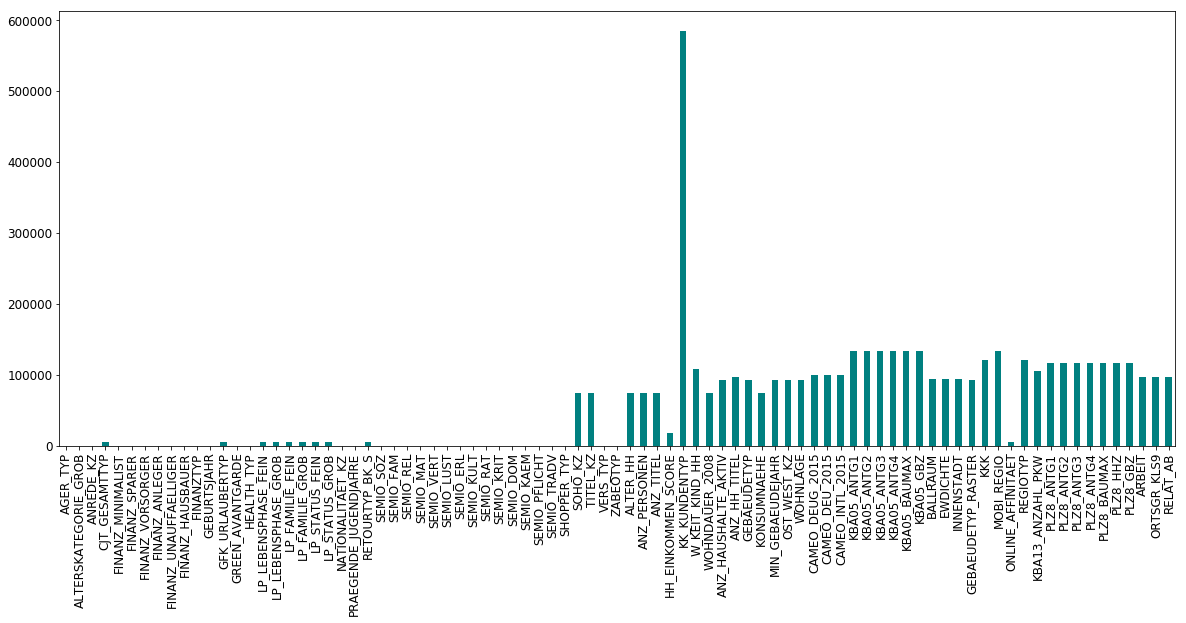

In [14]:
# Visualizing the naturally missing data
azdias.isnull().sum().plot.bar(figsize=(20,8),fontsize=12,color='teal');

In [15]:
# Deeper analysis of the variable KK_KUNDENTYP - Consumer pattern over 12 months
azdias['KK_KUNDENTYP'].value_counts()

3.0    65151
2.0    62564
5.0    48038
4.0    44512
6.0    44114
1.0    42230
Name: KK_KUNDENTYP, dtype: int64

In [16]:
# Identify missing or unknown data values and convert them to NaNs.
def convert_missing_to_nan(df):
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
            
    return df

In [17]:
azdias = convert_missing_to_nan(azdias)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Count value of Nan values in each column
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [19]:
sum(azdias.isnull().sum())

8373929

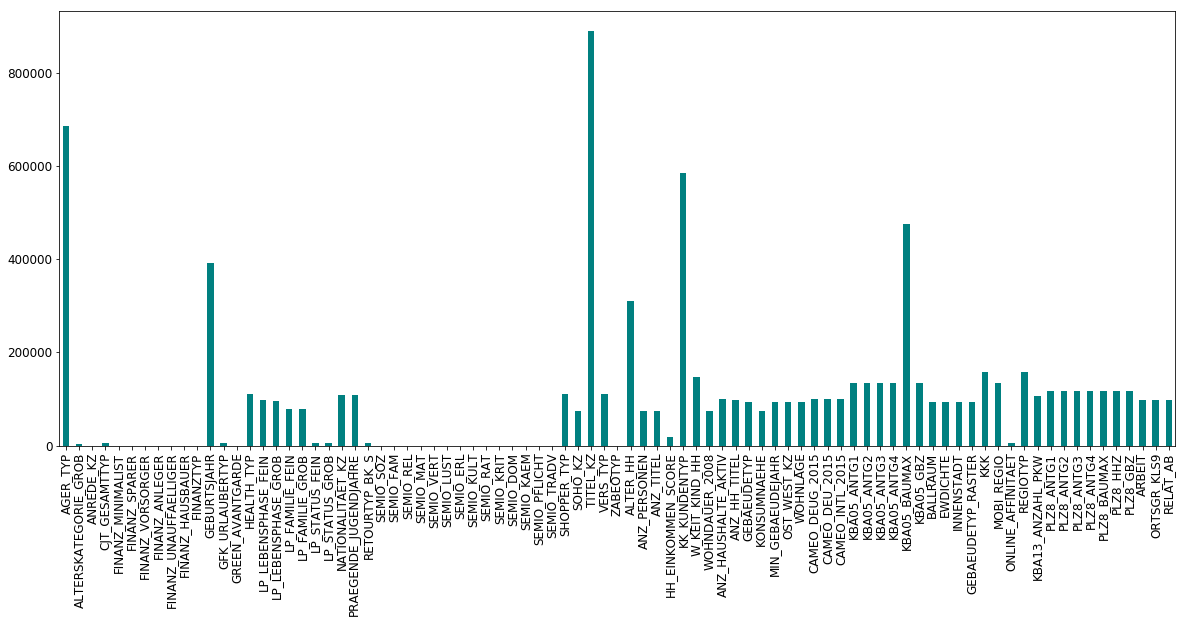

In [20]:
#Visualizing the columns with missing values
azdias.isnull().sum().plot.bar(figsize=(20,8),fontsize=12,color='teal');

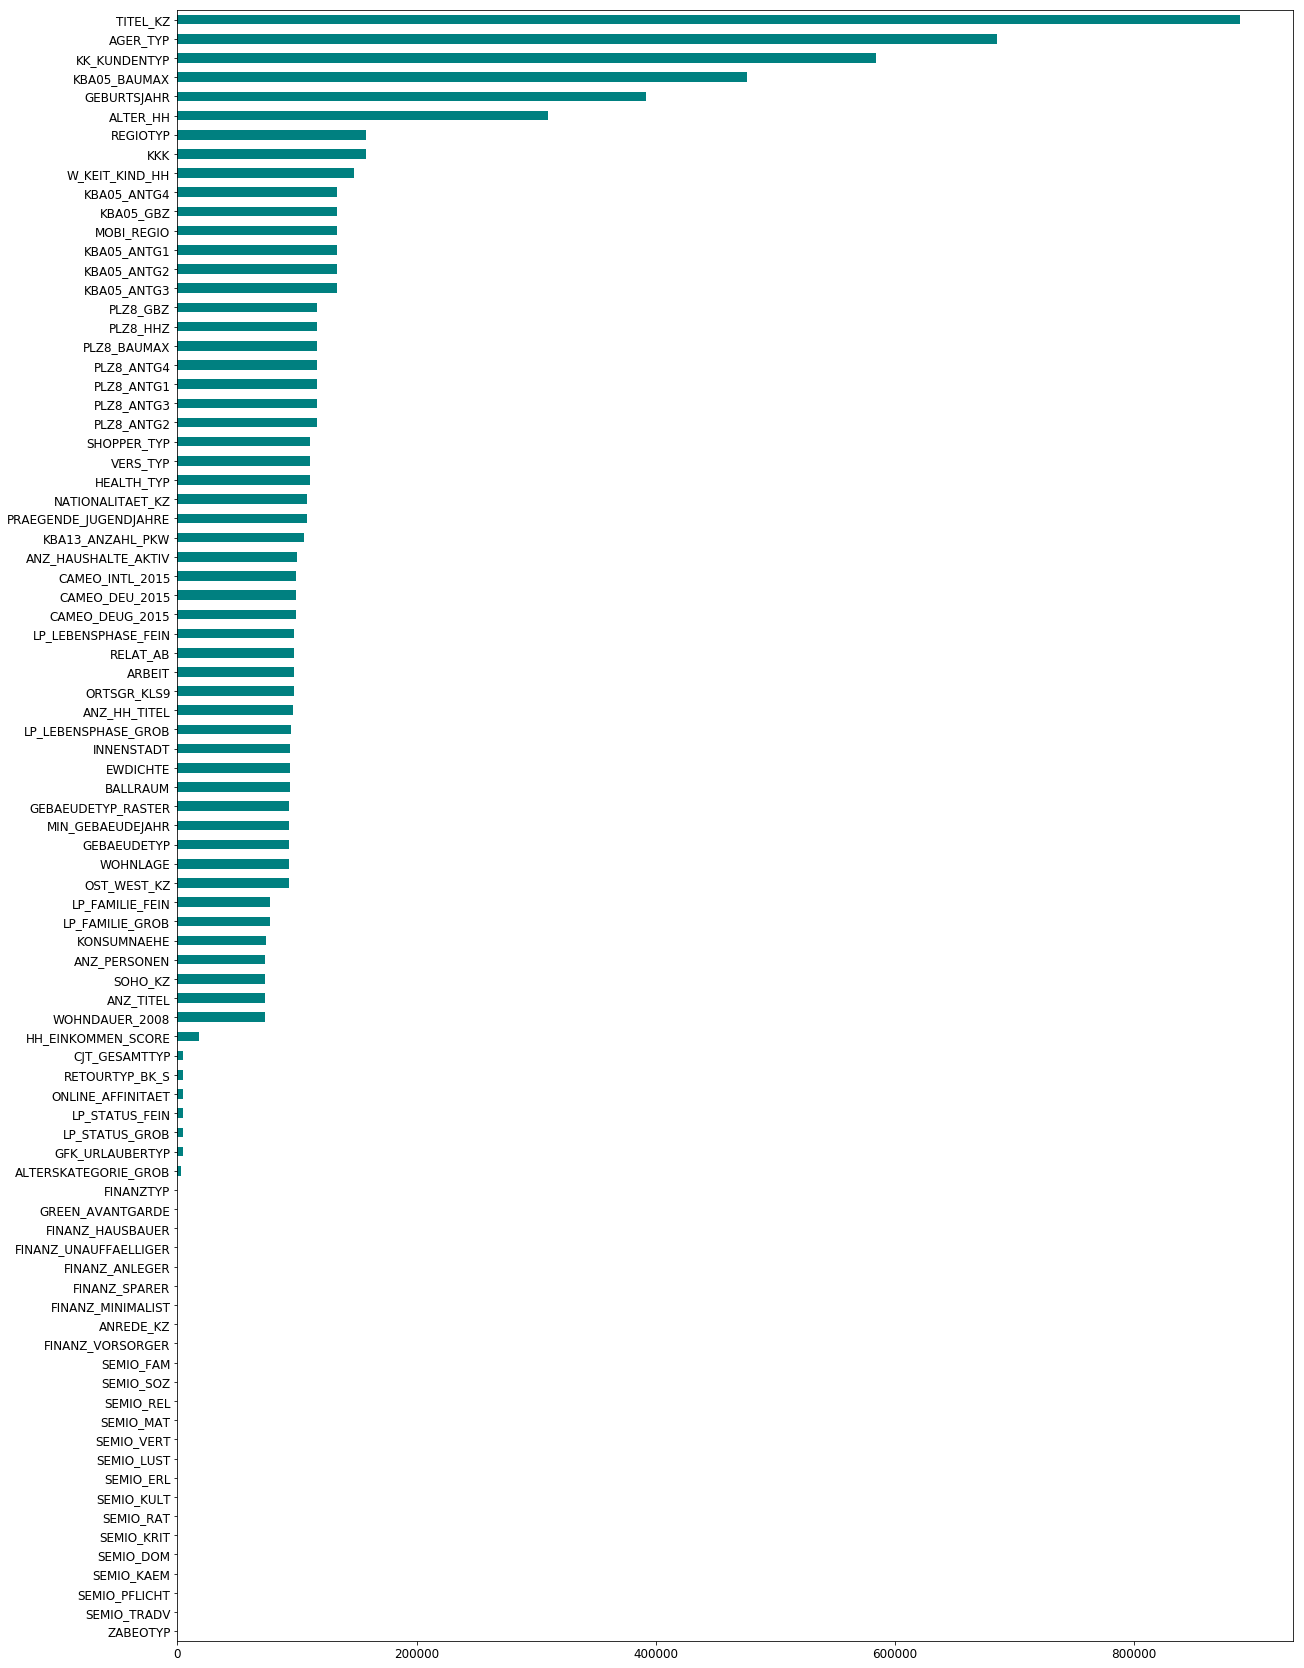

In [21]:
# Visualizing the missing data for each column sorted from highest to lowest.
azdias.isnull().sum().sort_values().plot.barh(figsize=(20,30),fontsize=12,color='teal');

In [22]:
# Calculating percentage of Nan values in descending order
round(azdias.isnull().sum()/azdias.shape[0]*100,1).sort_values(ascending=False)

TITEL_KZ                 99.8
AGER_TYP                 77.0
KK_KUNDENTYP             65.6
KBA05_BAUMAX             53.5
GEBURTSJAHR              44.0
ALTER_HH                 34.8
REGIOTYP                 17.7
KKK                      17.7
W_KEIT_KIND_HH           16.6
KBA05_ANTG4              15.0
KBA05_GBZ                15.0
MOBI_REGIO               15.0
KBA05_ANTG1              15.0
KBA05_ANTG2              15.0
KBA05_ANTG3              15.0
PLZ8_GBZ                 13.1
PLZ8_HHZ                 13.1
PLZ8_BAUMAX              13.1
PLZ8_ANTG4               13.1
PLZ8_ANTG1               13.1
PLZ8_ANTG3               13.1
PLZ8_ANTG2               13.1
SHOPPER_TYP              12.5
VERS_TYP                 12.5
HEALTH_TYP               12.5
NATIONALITAET_KZ         12.2
PRAEGENDE_JUGENDJAHRE    12.1
KBA13_ANZAHL_PKW         11.9
ANZ_HAUSHALTE_AKTIV      11.2
CAMEO_INTL_2015          11.1
CAMEO_DEU_2015           11.1
CAMEO_DEUG_2015          11.1
LP_LEBENSPHASE_FEIN      11.0
ORTSGR_KLS

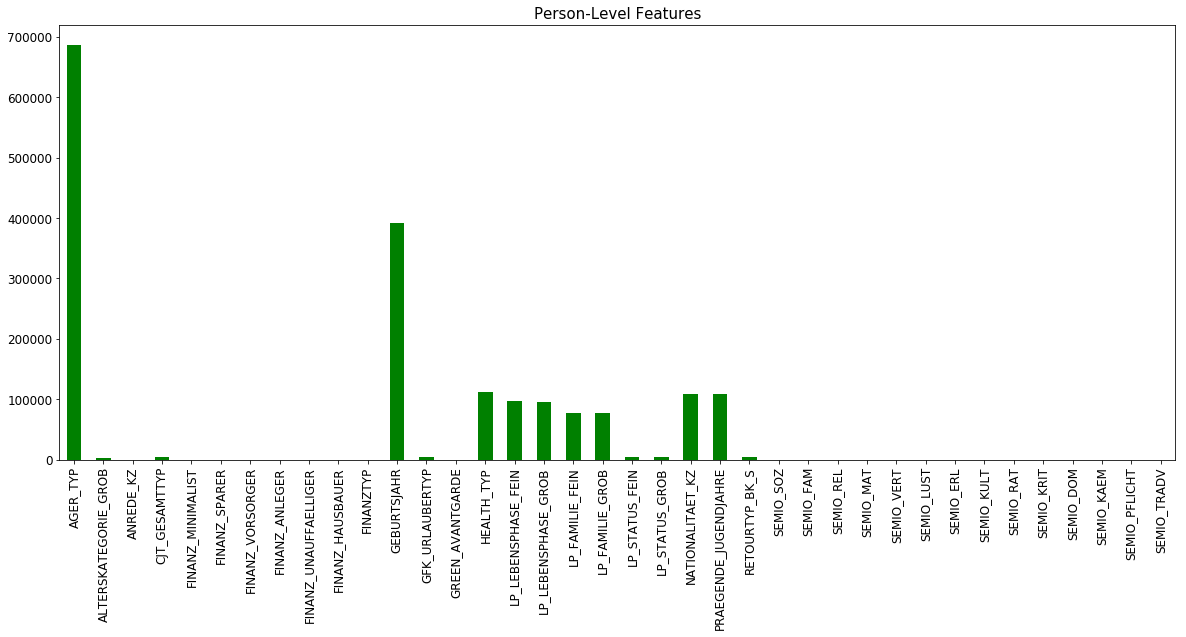

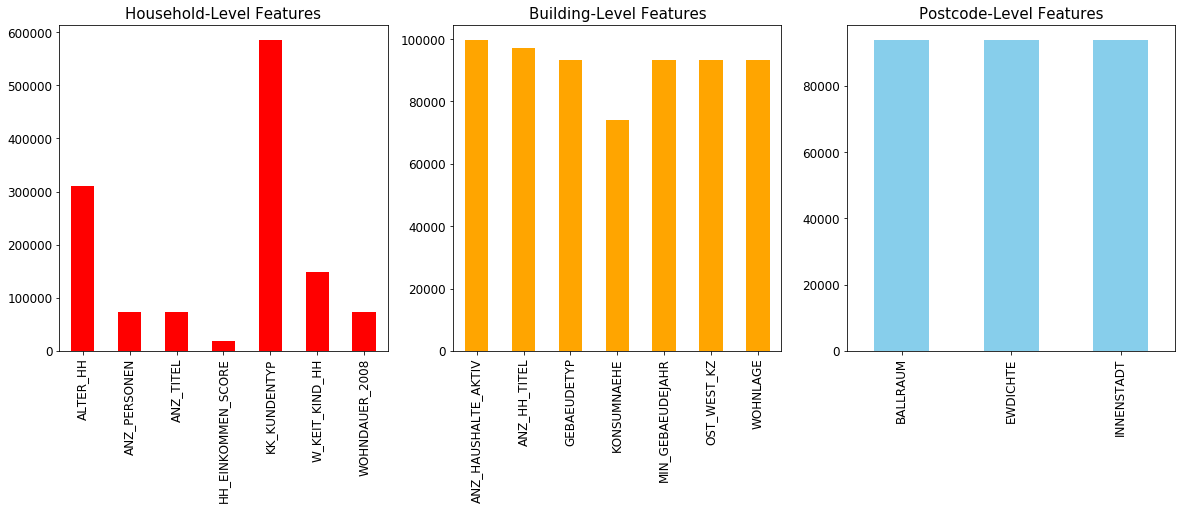

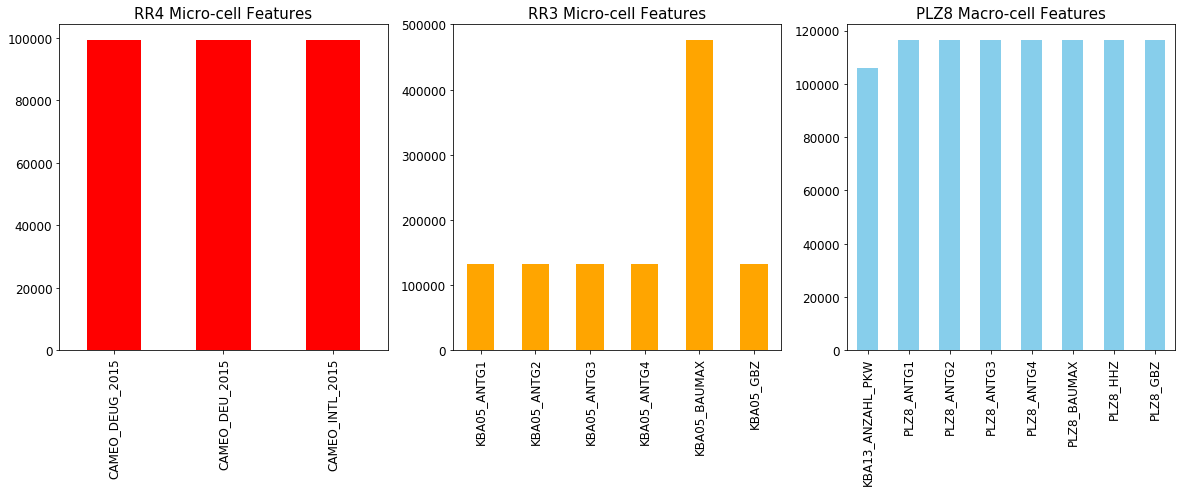

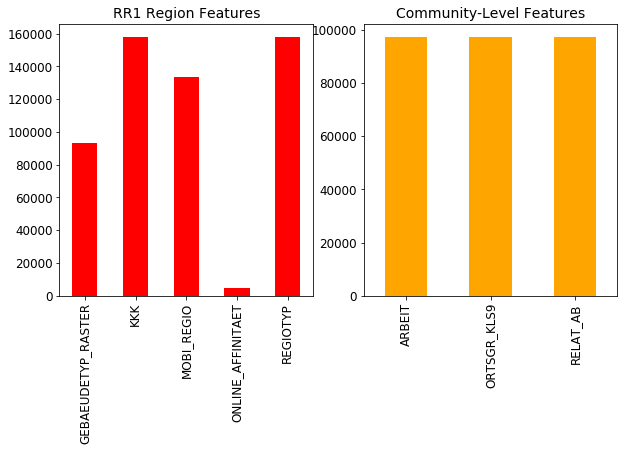

In [23]:
# Investigate patterns in the amount of missing data in each column.
# Visualize the missing data by each data group.

plt.figure(1,figsize=(20,8))
plt.subplot(111)
azdias.loc[:,'AGER_TYP':'SEMIO_TRADV'].isnull().sum().plot.bar(fontsize=12,color='green')
plt.title('Person-Level Features',fontsize=15)

plt.figure(2,figsize=(20,6))
plt.subplot(131)
azdias.loc[:,'ALTER_HH':'WOHNDAUER_2008'].isnull().sum().plot.bar(fontsize=12,color='red')
plt.title('Household-Level Features',fontsize=15)

plt.subplot(132)
azdias.loc[:,'ANZ_HAUSHALTE_AKTIV':'WOHNLAGE'].isnull().sum().plot.bar(fontsize=12,color='orange')
plt.title('Building-Level Features',fontsize=15)

plt.subplot(133)
azdias.loc[:,'BALLRAUM':'INNENSTADT'].isnull().sum().plot.bar(fontsize=12,color='skyblue')
plt.title('Postcode-Level Features',fontsize=15)

plt.figure(3,figsize=(20,6))
plt.subplot(131)
azdias.loc[:,'CAMEO_DEUG_2015':'CAMEO_INTL_2015'].isnull().sum().plot.bar(fontsize=12,color='red')
plt.title('RR4 Micro-cell Features',fontsize=15)

plt.subplot(132)
azdias.loc[:,'KBA05_ANTG1':'KBA05_GBZ'].isnull().sum().plot.bar(fontsize=12,color='orange')
plt.title('RR3 Micro-cell Features',fontsize=15)

plt.subplot(133)
azdias.loc[:,'KBA13_ANZAHL_PKW':'PLZ8_GBZ'].isnull().sum().plot.bar(fontsize=12,color='skyblue')
plt.title('PLZ8 Macro-cell Features',fontsize=15)

plt.figure(4,figsize=(10,5))
plt.subplot(121)
azdias.loc[:,'GEBAEUDETYP_RASTER':'REGIOTYP'].isnull().sum().plot.bar(fontsize=12,color='red')
plt.title('RR1 Region Features',fontsize=14)

plt.subplot(122)
azdias.loc[:,'ARBEIT':'RELAT_AB'].isnull().sum().plot.bar(fontsize=12,color='orange')
plt.title('Community-Level Features',fontsize=14)

plt.show()

In [24]:
# Remove the outlier columns from the dataset. (Columns with more than 30% of data missing)

azdias = azdias.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
azdias[:10]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [25]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

I'd like to start by saying my aim with the data wrangling is to maintain the highest level of relevant data to help construct accurate clusters that reflect the customer segments of the company.

From the analysis of the naturally missing data, we can see that the person-level features is the most complete with the least number of missing observations. The data seems to have been collected and assembled by feature level, as 5 of the 9 feature levels contain the same number of missing observations, namely RR4 Micro-cell has 98,979 missing observations, RR3 Micro-cell 133,324, Postcode-level 93,740, PLZ8 Macro-cell 116,515 and Community-level 97,216 missing observations. In the person-level features, there are 9 columns with 4,854 observations missing. 

"KK_Kundentyp" has the greatest number of observations missing at 584,612 observations or 66%. This category relates to consumer pattern over the past 12 months, so the presumption is missing observations were people from the population who were not a customer of the mail order company in the last 12 months. I think this column can de dropped from the dataset as the information is not useful in obtaining customer segments from the population. This information is part of the customer dataset. Decision drop "KK_Kundentyp".

Once the function to convert missing values from the feature summary file is added to the dataset, we have an increase in missing observations of 71% from 4,896,838 to 8,373,929. When we graph this data we can see 6 columns clearly stand out, all with over 30% missing information. Looking at each of the columns individually to determine their significance; "KK_Kundentyp" was discussed above. "TITEL_KZ" relates to an academic title and with 99.8% missing observations, this is a no brainer but to drop the column. "AGER_TYP" relates to a split in elderly persons, this information is partially found in other categories and can be also safely dropped without losing value. "KBA05_BAUMAX" is a summary of categories 5.1,5.2,5.3,5.4 and so can be safely dropped. "GEBURTSJAHR" relates to year of birth, since this information is genaralized in other person-level categories and with 44% of the information missing, imputing wouldn't make sense so I think better to drop also this column. Lastly "ALTER_HH" is again related to the date of birth of the head of the household and can be dropped for the same reasons as "GEBURTSJAHR".

Decision drop the 6 outlier columns of "TITEL_KZ", "AGER_TYP", "KK_KUDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR" and "ALTER_HH". 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
missing_row_data = azdias.isnull().sum(axis=1)
missing_row_data

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
30        34
31         0
32         0
33         0
34         4
35        43
36         0
37         0
38         0
39         5
40         4
41         0
42         2
43         0
44         0
45         0
46        40
47         0
48        47
49         0
50         0
51         0
52         0
53        43
54        47
55         0
56         0
57         0
58         0
59         0
60         4
61        43
62        43
63         0
64         5
65         0
66         0
67         0
68         0
69        47
70         7
71         0
72         1
73         8
74         0
75        47
76        43

In [27]:
# Aggregate missing row data by number of missing values per row
missing_row_data.value_counts().sort_index()

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

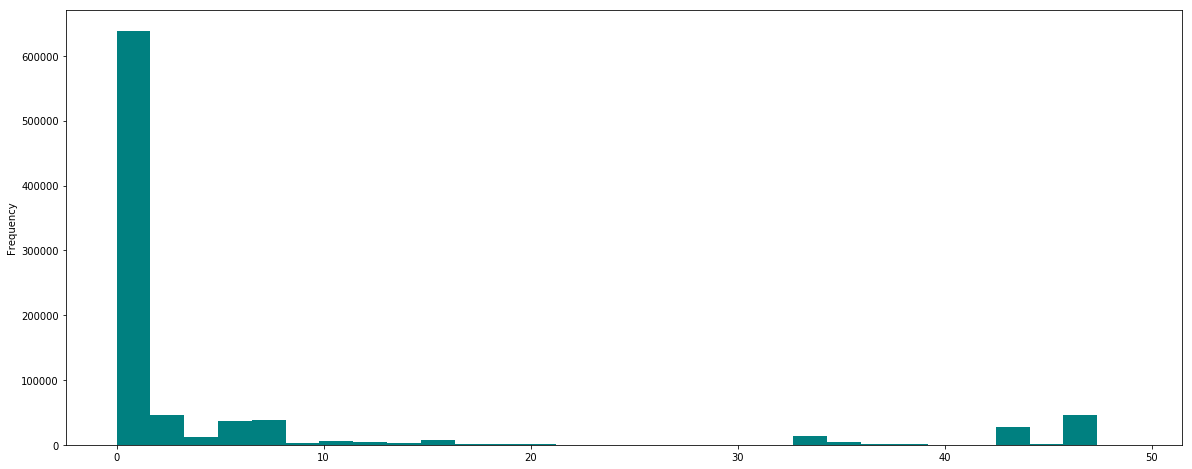

In [28]:
# Visualize counts of number of missing data points by row
missing_row_data.plot(kind='hist',bins=30,figsize=(20,8),color='teal');

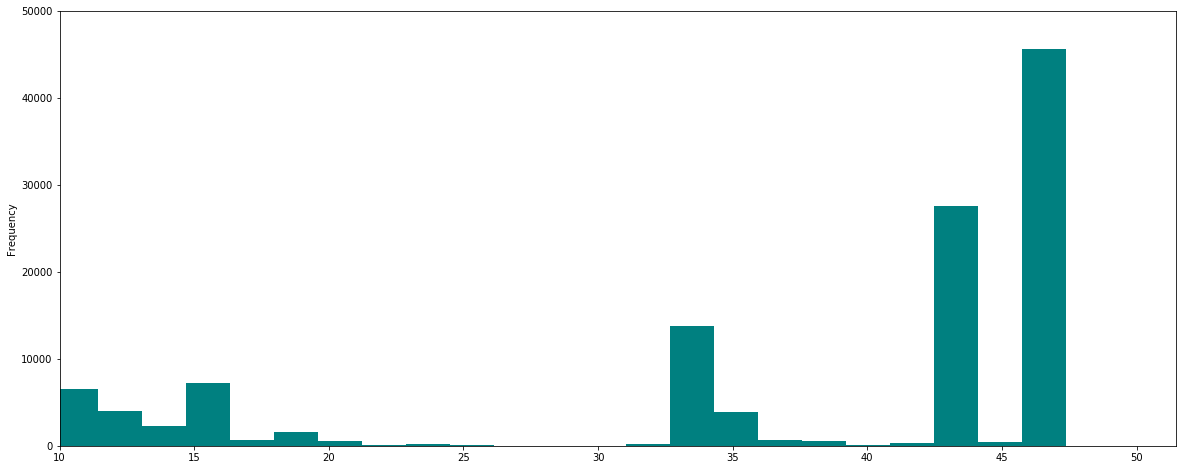

In [29]:
# Zoom in on missing rows from 10 missing data points
missing_row_data.plot(kind='hist',bins=30,figsize=(20,8),color='teal',xlim=10,ylim=(0,50000));

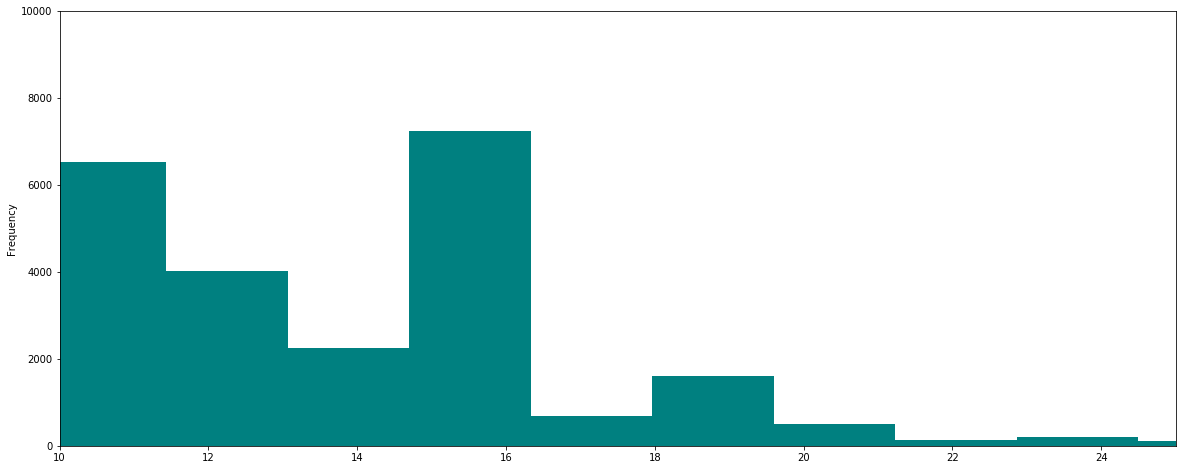

In [30]:
#Zoom in on area from 10 to 25 missing data points
missing_row_data.plot(kind='hist',bins=30,figsize=(20,8),color='teal',xlim=(10,25),ylim=(0,10000));

In [31]:
# Calculate percentage of data kept for rows with 9 or less missing data points
cumsum = round(missing_row_data.value_counts().sort_index().cumsum()[:9]/missing_row_data.shape[0]*100,1)
print("Percentage of data kept:",cumsum[8],"%")

Percentage of data kept: 86.6 %


In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_subset_1 = azdias[azdias.index.isin(missing_row_data[missing_row_data <= 9].index)]
azdias_subset_1

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,8.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5,2,3,5,5,6,6,1,4,7,4,7,5,3,2.0,0.0,2.0,3,1.0,0.0,6.0,6.0,9.0,6.0,0.0,1.0,4.0,1992.0,W,5.0,9,9D,51,0.0,4.0,1.0,0.0,2.0,6.0,4.0,4.0,5.0,4.0,1.0,1.0,7.0,424.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [33]:
azdias_subset_1.shape

(774743, 79)

In [34]:
azdias_subset_2 = azdias[azdias.index.isin(missing_row_data[missing_row_data > 9].index)]
azdias_subset_2

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2.0,2,4.0,4,3,1,4,5,1,3,11.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,5.0,2,5,4,3,2,2,5,3,6,7,6,5,5,7,1.0,0.0,1.0,3,1.0,0.0,2.0,3.0,4.0,1.0,0.0,3.0,5.0,2002.0,W,5.0,4,4C,24,1.0,0.0,0.0,0.0,5.0,5.0,2.0,6.0,1.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0
24,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,3.0,1,3.0,5,2,4,2,3,1,3,2.0,0,1.0,11.0,3.0,1.0,1.0,8.0,4.0,1.0,8.0,3.0,3,6,4,6,7,1,4,5,5,5,2,3,4,4,1.0,0.0,1.0,1,1.0,0.0,2.0,3.0,3.0,1.0,0.0,1.0,5.0,2015.0,W,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,3.0,7.0,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
30,3.0,2,3.0,4,3,4,4,4,1,3,11.0,0,2.0,7.0,2.0,1.0,1.0,4.0,2.0,1.0,8.0,2.0,2,1,1,2,4,1,6,1,4,7,6,7,4,3,3.0,0.0,2.0,3,1.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2.0,2,2.0,3,4,3,5,5,3,4,7.0,0,NaN,19.0,5.0,2.0,2.0,9.0,4.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,2,3.0,2,4,3,5,5,4,1,1.0,0,NaN,NaN,NaN,1.0,1.0,2.0,1.0,1.0,8.0,5.0,2,1,5,4,4,2,7,3,6,7,6,7,4,1,NaN,0.0,NaN,3,1.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
azdias_subset_2.shape

(116478, 79)

In [36]:
# Check all original rows have been accounted for and no data is missing
azdias_subset_1.shape[0] + azdias_subset_2.shape[0]

891221

In [37]:
# Header list names for reference for analysis between dataframes azdias subset 1 and 2
col_comparison = pd.Series(list(azdias_subset_1.columns.values))

In [38]:
# Comparison in the distributions of values for six columns where there are
# no or few missing values, between the two subsets.
def countplot(col1,col2,col3,col4,col5,col6):
    
    plt.figure(1,figsize=(16,4))
    
    plt.subplot(141)
    sns.countplot(x=azdias_subset_1[col1],color='skyblue',edgecolor='.9',data=azdias_subset_1)
    plt.title("Data Kept")

    plt.subplot(142)
    sns.countplot(x=azdias_subset_2[col1],color='lightgreen',edgecolor='.9',data=azdias_subset_2)
    plt.title("Data Rejected")
    
    plt.subplot(143)
    sns.countplot(x=azdias_subset_1[col2],color='skyblue',edgecolor='.9',data=azdias_subset_1)
    plt.title("Data Kept")

    plt.subplot(144)
    sns.countplot(x=azdias_subset_2[col2],color='lightgreen',edgecolor='.9',data=azdias_subset_2)
    plt.title("Data Rejected")
    
    plt.subplots_adjust(wspace = 0.5)
    
    plt.figure(2,figsize=(16,4))
    
    plt.subplot(141)
    sns.countplot(x=azdias_subset_1[col3],color='skyblue',edgecolor='.9',data=azdias_subset_1)
    plt.title("Data Kept")

    plt.subplot(142)
    sns.countplot(x=azdias_subset_2[col3],color='lightgreen',edgecolor='.9',data=azdias_subset_2)
    plt.title("Data Rejected")
    
    plt.subplot(143)
    sns.countplot(x=azdias_subset_1[col4],color='skyblue',edgecolor='.9',data=azdias_subset_1)
    plt.title("Data Kept")

    plt.subplot(144)
    sns.countplot(x=azdias_subset_2[col4],color='lightgreen',edgecolor='.9',data=azdias_subset_2)
    plt.title("Data Rejected")
    
    plt.subplots_adjust(wspace = 0.5)
    
    plt.figure(3,figsize=(16,4))
    
    plt.subplot(141)
    sns.countplot(x=azdias_subset_1[col5],color='skyblue',edgecolor='.9',data=azdias_subset_1)
    plt.title("Data Kept")

    plt.subplot(142)
    sns.countplot(x=azdias_subset_2[col5],color='lightgreen',edgecolor='.9',data=azdias_subset_2)
    plt.title("Data Rejected")
    
    plt.subplot(143)
    sns.countplot(x=azdias_subset_1[col6],color='skyblue',edgecolor='.9',data=azdias_subset_1)
    plt.title("Data Kept")

    plt.subplot(144)
    sns.countplot(x=azdias_subset_2[col6],color='lightgreen',edgecolor='.9',data=azdias_subset_2)
    plt.title("Data Rejected")
    
    
    plt.subplots_adjust(wspace = 0.5)
    plt.show();


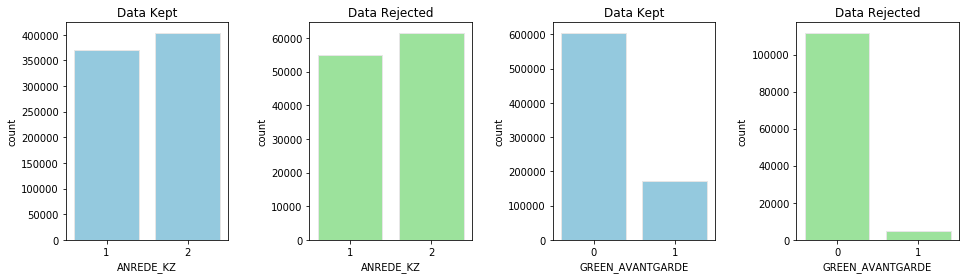

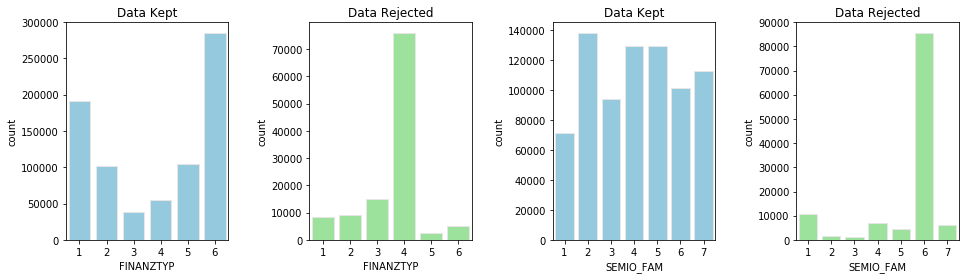

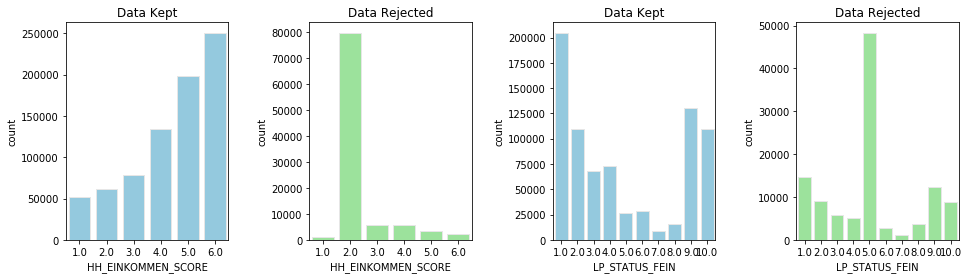

In [39]:
# Columns chosen manually with zero or almost zero missing data 
countplot('ANREDE_KZ','GREEN_AVANTGARDE','FINANZTYP','SEMIO_FAM','HH_EINKOMMEN_SCORE','LP_STATUS_FEIN')

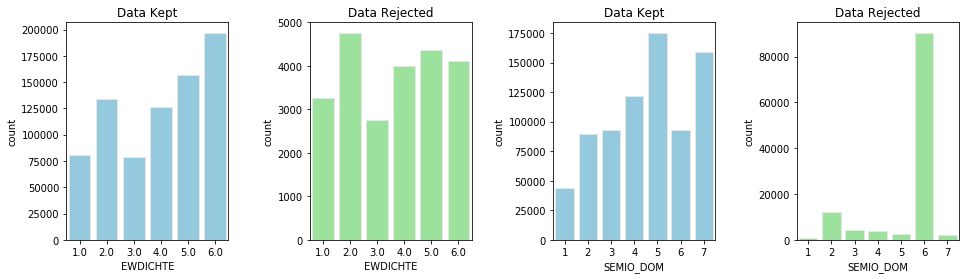

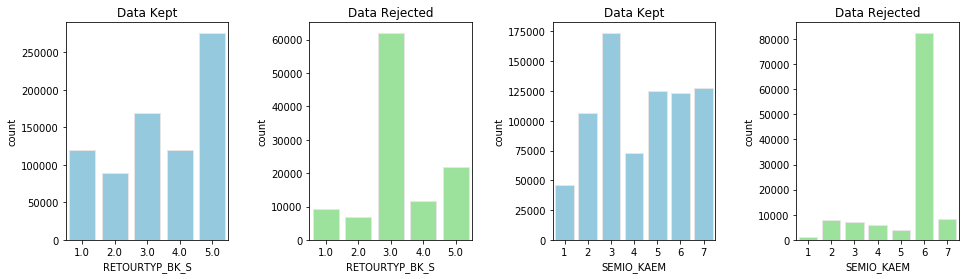

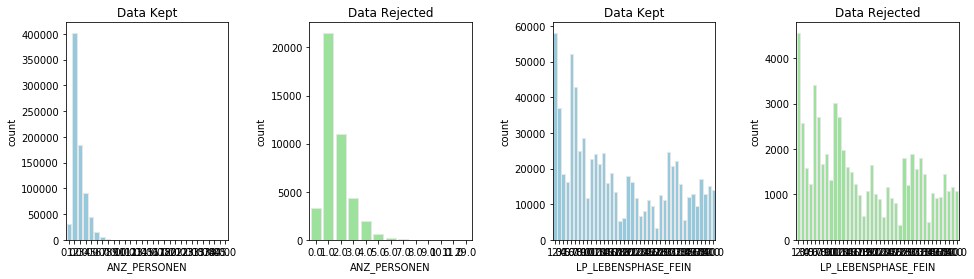

In [51]:
# 6 columns chosen at random for comparison
s = list(col_comparison.sample(n=6))
countplot(s[0],s[1],s[2],s[3],s[4],s[5])

In [39]:
# Checkpoint of azdias dataset taken
azdias_subset_1.to_csv('azdias_checkpoint_1.csv',sep=';',encoding='utf-8',index=False)

In [40]:
# Load from checkpoint
azdias_2 = pd.read_csv('azdias_checkpoint_1.csv',sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Keeping in mind that our aim is to maintain the highest level of relevant data to help construct accurate clusters that can be used to find customer segments for the company.

First of all, we can see 623,209 rows are complete out of a total of 891,221 or 69.9%.

From the plots, we can see common missing number of observations in rows are 34, 45 and 47 missing observations with a combined total of 83,763 rows or 9.4%. With so many missing values I think the reliability and usefulness of these observations are limited, and the best decision is to drop them.

So zooming in on the plot we can see some natural breaks into the data at missing number of values at 9, 11, 17 and 20. The cumulative percentage of data retained at each of these cut off points are respectively; 9:86.6%, 11:87.7%, 17:89.3% and 20:89.5%. This means a difference of keeping an extra 25,376 rows between 9 missing observations on a row and 20 missing observations on a row.

Considering that the clustering algorithm K-means requires no missing information to work and that the dataset is made up of mainly ordinal and categorical data, where imputing values with means, modes or medians can impact the truth of the dataset much more than if the dataset was made up of numerical data. On balance, it seems more appropriate to minimize imputing missing data and maintain the integrity at maximum. 

Therefore, the decision is to delete all rows with more than 9 missing observations on the row, thus keeping 774,743 rows (86.6%) and discarding the remaining 116,478 rows.

  "It was a tough decision between discarding all rows with missing observations, therefore keeping 70% of the data but no imputation and the 9 missing rows, so keeping 87% of the data but imputing 148,492 values on the datset. To be honest in a real-world scenario I think I would have discarded all rows with any missing observations, on the basis that the German population over 18 is around 70 million. Therefore the difference between the two sample choices on the overall population is 0.2%. But I'm doing this course to learn so I want to do all the steps and practice everything."  

With regards the data discarded with more than 9 missing observations. At first glance, the distributions within the variables in the most part seem different. Looking more closely at some of the variables manually chosen that have no missing observations only the gender "ANREDE_KZ" seems comparable, if you look at "HH_EINKOMMEN_SCORE" which shows an household net income the overwhelming majority of rows rejected show a 2 or very high income. This is also reflected in "LP_STATUS_FEIN" where the overwhelming majority of rows rejected are a 5 or minimalistic high-income earners. The missing observations in rows could relate to the extra privacy laws that protect high earners due the ease of being able to identify them from information. This would need more investigation to confirm. 

Other categories in the rejected data are also highly different in distribution, for example "RETOURTYP_BK_S", "SEMIO_FAM", "SEMIO_KAEM" and "SEMIO_DOM", and so we can conclude that the discarded rows are qualitatively different to the rows that have been kept.  


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
# How many features are there of each data type?
print(feat_info['type'].value_counts())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


In [42]:
# Look at the categorical features
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Remove from feat_info dataframe colums that have already been deleted

feat_info = feat_info[feat_info.attribute != 'TITEL_KZ']
feat_info = feat_info[feat_info.attribute != 'AGER_TYP']
feat_info = feat_info[feat_info.attribute != 'KK_KUNDENTYP']
feat_info = feat_info[feat_info.attribute != 'KBA05_BAUMAX']
feat_info = feat_info[feat_info.attribute != 'GEBURTSJAHR']
feat_info = feat_info[feat_info.attribute != 'ALTER_HH']

In [44]:
# Create a dataframe with only categorical variables
categorical_variables = azdias_2[feat_info[feat_info['type'] == 'categorical']['attribute']]
categorical_variables

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8.0,8A
1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4.0,4C
2,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2.0,2A
3,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6.0,6B
4,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8.0,8C
5,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4.0,4A
6,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2.0,2D
7,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1.0,1A
8,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1.0,1E
9,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,3,1.0,W,9.0,9D


In [45]:
# List for reference of categorical variables
categorical_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774743 entries, 0 to 774742
Data columns (total 18 columns):
ANREDE_KZ           774743 non-null int64
CJT_GESAMTTYP       774743 non-null float64
FINANZTYP           774743 non-null int64
GFK_URLAUBERTYP     774743 non-null float64
GREEN_AVANTGARDE    774743 non-null int64
LP_FAMILIE_FEIN     750265 non-null float64
LP_FAMILIE_GROB     750265 non-null float64
LP_STATUS_FEIN      774743 non-null float64
LP_STATUS_GROB      774743 non-null float64
NATIONALITAET_KZ    743919 non-null float64
SHOPPER_TYP         741323 non-null float64
SOHO_KZ             774743 non-null float64
VERS_TYP            741323 non-null float64
ZABEOTYP            774743 non-null int64
GEBAEUDETYP         774743 non-null float64
OST_WEST_KZ         774743 non-null object
CAMEO_DEUG_2015     771287 non-null float64
CAMEO_DEU_2015      771287 non-null object
dtypes: float64(12), int64(4), object(2)
memory usage: 106.4+ MB


In [46]:
# Separate the categorical variables into binary or multi-variable
binary = []
multivar = []
for x in categorical_variables:
    if len(categorical_variables[x].value_counts()) == 2:
        binary.append(x)
    else:
        multivar.append(x)

In [47]:
# Binary list
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [48]:
# Multi-variable list
multivar

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [49]:
# Find binary categorical variable non-numeric
azdias_2['ANREDE_KZ'].unique()

array([2, 1])

In [50]:
# Find binary categorical variable non-numeric
azdias_2['GREEN_AVANTGARDE'].unique()

array([0, 1])

In [51]:
# Find binary categorical variable non-numeric
azdias_2['SOHO_KZ'].unique()

array([1., 0.])

In [52]:
# Find binary categorical variable non-numeric
azdias_2['VERS_TYP'].unique()

array([ 2.,  1., nan])

In [53]:
# Find binary categorical variable non-numeric - located it
azdias_2['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [54]:
# Change 'OST_WEST_KZ into numerical values
azdias_2['OST_WEST_KZ'] = azdias_2['OST_WEST_KZ'].map({'W': 1, 'O': 0})

In [55]:
# Analysis of column "GEBAEUDETYP"
azdias_2['GEBAEUDETYP'].value_counts().sort_index()

1.0    444164
2.0      4294
3.0    174605
4.0       809
5.0         1
6.0       548
8.0    150322
Name: GEBAEUDETYP, dtype: int64

In [56]:
# Simplify 'GEBAEUDETYP' Type of building use into 3 categories; 1 = residential, 2 = mixed usage, 3 = commercial
azdias_2['GEBAEUDETYP'] = azdias_2['GEBAEUDETYP'].map({1:1,2:1,3:2,4:2,5:3,6:2,7:3,8:2})

In [57]:
# Check mapping has worked - After reviewing these numbers decided to drop as provide no added value information 
# for customer segmentation.
azdias_2['GEBAEUDETYP'].value_counts().sort_index()

1    448458
2    326284
3         1
Name: GEBAEUDETYP, dtype: int64

In [58]:
# Deep analysis of multi-variable category CAMEO_DEU_2015
azdias_2['CAMEO_DEU_2015'].value_counts().sort_index()

1A    10571
1B     3970
1C     4188
1D    11699
1E     4946
2A    12795
2B    14906
2C    18731
2D    34105
3A     8698
3B     6668
3C    33893
3D    33401
4A    31990
4B     8745
4C    46283
4D     8383
4E     5186
5A    11074
5B    10087
5C     9571
5D    14594
5E     3517
5F     4183
6A     6647
6B    55429
6C    14502
6D     5956
6E    15838
6F     5263
7A    33648
7B    23954
7C     8920
7D     5234
7E     4509
8A    51807
8B    32828
8C    30591
8D    17337
9A    20258
9B    27359
9C    24705
9D    28215
9E     6103
Name: CAMEO_DEU_2015, dtype: int64

In [59]:
# Drop multi-variable columns not required
cols_to_drop = ['LP_FAMILIE_GROB','LP_STATUS_GROB','GEBAEUDETYP','CAMEO_DEU_2015']
azdias_2 = azdias_2.drop(cols_to_drop,axis=1)

In [60]:
# Re-encode categorical variable(s) to be kept in the analysis.
multi = []

for x in multivar:
    if x not in cols_to_drop:
        multi.append(x)
        
multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'CAMEO_DEUG_2015']

In [61]:
# One Hot Encode remaining multi-variable categorical variables
azdias_2 = pd.get_dummies(azdias_2, columns = multi, prefix=multi)

In [62]:
azdias_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [63]:
azdias_2.shape

(774743, 133)

#### Discussion 1.2.1: Re-Encode Categorical Features

For the categorical features, I first isolated which columns classed as categorical and separated them between binary variables i.e. ones with 2 values and multiple variables.

The 5 binary categorical features, all give information that I think could be relevant for forming customer segments so the decision was to keep them all including the non-numerical one which related to whether the building in which the individual lives is in what was the old East or West Germany prior to 1991. After 27 years this feature is probably waning in usefulness compared to 10 or 20 years ago when analysing customer segments.

For the multi categorical variables, I analysed each individually:
The following categories ("CJT_GESAMTTYP", "FINANZTYP", "NATIONALITAET_KZ", "SHOPPER_TYP","ZABEOTYP") all related to person-level features without being too detailed so the decision was to keep them and one hot encode them.

For "LP_FAMILIE_FEIN","LP_FAMILIE_GROB","LP_STATUS_FEIN", and "LP_STATUS_GROB', the decision was to drop the Grobs which were summaries of the Feins. I thought the level of segregation was better for identifying customer segments in the more detailed Fein scales but it was unnecessary to keep both.

The category "GEBAEUDETYP" once summarized provided no additional value for customer segmentation as it related to building-level feature which could be inferred from 3.1 "ANZ_HAUSHALTE_AKTIV" so it was decided to drop it.

Between "CAMEO_DEUG_2015", and "CAMEO_DEU_2015", which both relate to wealth/life stage typology with the first using a rough scale and the second a very detailed marketing scale. I decided to keep only the rough scale. When you look through all the categories in the feature info list, the majority are at a higher level in detail to "CAMEO_DEU_2015". "CAMEO_DEU_2015" seems to be a level of detail too high for this particular customer segment analysis, I think it would be appropriate to use this in a second analysis after primary customer segments have been identified for fine-tuning marketing efforts. Also there are many categories and one hot encoding these would add many features to our analysis and I am not convinced it would add value to this particular segment analysis. 

Lastly, "GFK_URLAUBERTYP" is a detailed analysis of vacation habits with 12 categories. It was a close choice on whether to keep or drop for the same reasons discussed in the paragraph above on the level of detail for this particular analysis. On the balance of number of categories and that it was a person-level feature I have kept it and one hot encoded it.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
# Identify features classified as mixed
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [65]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_2['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    177574
8.0     137903
10.0     83394
5.0      83112
3.0      52758
15.0     40803
11.0     34385
9.0      32939
6.0      25311
12.0     23925
4.0      20185
1.0      20106
2.0       7387
13.0      5520
7.0       3939
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [66]:
# Engineer a column "AVANTGARDE" 
avantgarde = []

for x in azdias_2['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        avantgarde.append(0) # Value 0 denotes 'Mainstream'
    elif x in [2,4,6,7,9,11,13,15]:
        avantgarde.append(1) # Value 1 denotes 'Avantgarde'
    else:
        avantgarde.append(np.nan)

In [67]:
# Add new column "AVANTGARDE" to azdias dataframe
a = pd.Series(avantgarde)
azdias_2['AVANTGARDE'] = a.values
azdias_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1.0
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.0
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0
4,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0


In [68]:
# Check engineering successful
azdias_2['AVANTGARDE'].value_counts()

0.0    578772
1.0    170469
Name: AVANTGARDE, dtype: int64

In [69]:
# Engineer new column "DEKADE" based on decade of birth
azdias_2['DEKADE'] = azdias_2['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

In [70]:
# Check engineering
azdias_2['DEKADE'].value_counts().sort_index()

1.0     27493
2.0     72943
3.0    112362
4.0    170842
5.0    147224
6.0    218377
Name: DEKADE, dtype: int64

In [71]:
# Drop original column from dataframe
azdias_2 = azdias_2.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [72]:
# Check dataframe
azdias_2[:10]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,6.0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1.0,6.0
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.0,4.0
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,4.0
4,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0,2.0
5,2.0,2,1,5,1,5,4,3,0,2.0,2.0,1.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,1,5.0,22.0

In [73]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_2['CAMEO_INTL_2015'].value_counts()

51.0    132086
41.0     90430
24.0     88559
14.0     60994
43.0     55429
54.0     44745
25.0     38587
22.0     31990
45.0     25610
13.0     25477
23.0     24111
55.0     23440
52.0     20258
34.0     18111
31.0     17721
15.0     16645
44.0     14502
12.0     12795
35.0     10139
32.0     10087
33.0      9571
Name: CAMEO_INTL_2015, dtype: int64

In [74]:
# Engineer a feature based on household wealth
cameo_wealth = []

for x in azdias_2['CAMEO_INTL_2015']:
    if 10 < x < 16:
        cameo_wealth.append(5)
    elif 20 < x < 26:
        cameo_wealth.append(4)
    elif 30 < x < 36:
        cameo_wealth.append(3)
    elif 40 < x < 46:
        cameo_wealth.append(2)
    elif 50 < x < 56:
        cameo_wealth.append(1)
    else:
        cameo_wealth.append(np.nan)

In [75]:
cw = pd.Series(cameo_wealth)
azdias_2['CAMEO_WEALTH'] = cw.values

In [76]:
azdias_2['CAMEO_WEALTH'].value_counts().sort_index()

1.0    220529
2.0    185971
3.0     65629
4.0    183247
5.0    115911
Name: CAMEO_WEALTH, dtype: int64

In [77]:
# Engineer a feature based on household lifestage
cameo_lifestage = []

for x in azdias_2['CAMEO_INTL_2015']:
    if x % 10 == 1:
        cameo_lifestage.append(1)
    elif x % 10 == 2:
        cameo_lifestage.append(2)
    elif x % 10 == 3:
        cameo_lifestage.append(3)
    elif x % 10 == 4:
        cameo_lifestage.append(4)
    elif x % 10 == 5:
        cameo_lifestage.append(5)
    else:
        cameo_lifestage.append(np.nan)
        

In [78]:
cl = pd.Series(cameo_lifestage)
azdias_2['CAMEO_LIFESTAGE'] = cl.values

In [79]:
azdias_2['CAMEO_LIFESTAGE'].value_counts().sort_index()

1.0    240237
2.0     75130
3.0    114588
4.0    226911
5.0    114421
Name: CAMEO_LIFESTAGE, dtype: int64

In [80]:
# Remove original column
azdias_2 = azdias_2.drop(['CAMEO_INTL_2015'],axis=1)

In [81]:
# Verify re-engineering of "CAMEO_INTL_2015
azdias_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,6.0,1.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1.0,6.0,4.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.0,4.0,5.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,4.0,2.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0,2.0,1.0,4.0


In [82]:
azdias_2['WOHNLAGE'].value_counts().sort_index()

0.0      2941
1.0     42859
2.0     98105
3.0    244502
4.0    133116
5.0     72346
7.0    165983
8.0     14891
Name: WOHNLAGE, dtype: int64

In [83]:
# Engineer a feature based on rural or not
azdias_2['RURAL'] = azdias_2['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

In [84]:
# Engineer a feature based on quality of neighborhood
azdias_2['GEGEND'] = azdias_2['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [85]:
# Drop mixed features not required
azdias_2 = azdias_2.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],axis=1)

In [86]:
azdias_2.shape

(774743, 133)

In [87]:
# Check dataframe features
azdias_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,GEGEND
0,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,6.0,1.0,1.0,0,4
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1.0,6.0,4.0,4.0,0,2
2,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.0,4.0,5.0,2.0,1,0
3,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,4.0,2.0,3.0,0,3
4,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0,2.0,1.0,4.0,1,0


#### Discussion 1.2.2: Engineer Mixed-Type Features

The 2 variables "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were re-engineered into 4 new features as required at the start of this section. ("AVANTGARDE", "DEKADE", "CAMEO_WEALTH" and "CAMEO_LIFESTAGE")

The "CAMEO_INTL_2015" was interesting as the wealth feature engineered is very similar to the "CAMEO_DEUG_2015" categorical feature one hot encoded in the previous section. I thought about whether both features were necessary. After consideration I concluded that even though the "CAMEO_INTL_2015" was created from the German "CAMEO", the slightly different classifications could allow for a more refined cluster analysis. So I decided to keep both instead of dropping one.

For other mixed-type features ('LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB') were dropped on the basis that the information in these features were already included in other features in the dataset, 1.2 "ALTERSKATEGORIE_GROB", 1.13 "LP_FAMILIE_FEIN" and 1.15 "LP_STATUS_FEIN" and it wasn't necessary to re-engineer and keep them in the dataset.

For "KBA05_BAUMAX", again this feature was a summary of other features in the RR3 micro-cell category and was deemed unnecessary to re-engineer and keep.

However, for the last feature, 'WOHNLAGE', I thought the quality of the neighborhood could impact customer segments and this information wasn't available in other features, I re-engineered "WOHNLAGE" into 2 features, the first a binary categorical feature, whether the neighbourhood was rural or not, and the second into a rating class for the neighborhood. For rural neighborhoods I classed them as no score calculated. 



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [88]:
# Review of features 
azdias_2[:1].transpose()

,0
ALTERSKATEGORIE_GROB,1.0
ANREDE_KZ,2.0
FINANZ_MINIMALIST,1.0
FINANZ_SPARER,5.0
FINANZ_VORSORGER,2.0
FINANZ_ANLEGER,5.0
FINANZ_UNAUFFAELLIGER,4.0
FINANZ_HAUSBAUER,5.0
GREEN_AVANTGARDE,0.0
HEALTH_TYP,3.0


In [89]:
# Drop column "MIN_GEBAEUDEJAHR" for irrelevance to customer segments
azdias_2 = azdias_2.drop('MIN_GEBAEUDEJAHR',axis=1)

In [90]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_2.to_csv('azdias_checkpoint_2.csv',sep=';',encoding='utf-8',index=False)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [91]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
        
    # remove selected columns and rows, ...
    df = df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
    missing_row_data = df.isnull().sum(axis=1)
    df = df[df.index.isin(missing_row_data[missing_row_data <= 9].index)]
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df = df.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','GEBAEUDETYP','CAMEO_DEU_2015'],axis=1)
    multi = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN',
             'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','CAMEO_DEUG_2015']
    
    #df['LP_FAMILIE_FEIN'] = df['LP_FAMILIE_FEIN'].astype(float)
    #df['LP_STATUS_GROB'] = df['LP_STATUS_GROB'].astype(float)
    #df['GEBAEUDETYP'] = df['GEBAEUDETYP'].astype(float)
    #df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    df = pd.get_dummies(df, columns = multi, prefix=multi)
    
    avantgarde = []

    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            avantgarde.append(0) # Value 0 denotes 'Mainstream'
        elif x in [2,4,6,7,9,11,13,15]:
            avantgarde.append(1) # Value 1 denotes 'Avantgarde'
        else:
            avantgarde.append(np.nan)
    
    a = pd.Series(avantgarde)
    df['AVANTGARDE'] = a.values
    
    df['DEKADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,
                        2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    cameo_wealth = []
    for x in df['CAMEO_INTL_2015']:
        x = float(x)
        if 10 < x < 16:
            cameo_wealth.append(5)
        elif 20 < x < 26:
            cameo_wealth.append(4)
        elif 30 < x < 36:
            cameo_wealth.append(3)
        elif 40 < x < 46:
            cameo_wealth.append(2)
        elif 50 < x < 56:
            cameo_wealth.append(1)
        else:
            cameo_wealth.append(np.nan)

    cw = pd.Series(cameo_wealth)
    df['CAMEO_WEALTH'] = cw.values
    
    cameo_lifestage = []
    for x in df['CAMEO_INTL_2015']:
        x = float(x)
        if x % 10 == 1:
            cameo_lifestage.append(1)
        elif x % 10 == 2:
            cameo_lifestage.append(2)
        elif x % 10 == 3:
            cameo_lifestage.append(3)
        elif x % 10 == 4:
            cameo_lifestage.append(4)
        elif x % 10 == 5:
            cameo_lifestage.append(5)
        else:
            cameo_lifestage.append(np.nan)
            
    cl = pd.Series(cameo_lifestage)
    df['CAMEO_LIFESTAGE'] = cl.values
    
    df['RURAL'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['GEGEND'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','MIN_GEBAEUDEJAHR'],
                 axis=1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [92]:
# Load last checkpoint
azdias_3 = pd.read_csv('azdias_checkpoint_2.csv',sep=';')

In [93]:
# Check shape
azdias_3.shape

(774743, 132)

In [94]:
# Take a list of column headers
header_list = list(azdias_3.columns.values)
header_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'CJT_GESAMTTYP_1.0',
 'CJT_GESAMTT

In [95]:
# Impute nans using mode value
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
azdias_3 = imputer.fit_transform(azdias_3)
azdias_3 = pd.DataFrame(azdias_3)
azdias_3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,1.0,0.0,4.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,4.0,4.0,0.0,2.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0,1.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0


In [96]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_3 = scaler.fit_transform(azdias_3)
azdias_3 = pd.DataFrame(azdias_3,columns=header_list)
azdias_3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,GEGEND
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,-1.676217,0.433813,-0.057065,0.006223,-0.454567,-1.685272,-1.119340,-1.436264,-0.582872,1.276931,-0.306598,1.335425,-0.157807,1.505587,1.289283,10.876643,0.917469,0.229518,-0.060656,1.011072,-0.736877,0.55372,0.166144,-0.1257,-1.299512,0.519166,-1.028772,-0.984229,-0.603458,2.697903,-1.644175,0.847316,-0.553405,1.704090,-0.797041,-0.786251,-1.313537,0.180081,-0.873241,0.983350,-0.258072,0.213141,0.406235,0.422301,1.435587,0.563825,-0.179238,-0.132956,0.679358,-0.365261,-0.468594,-0.476736,-0.576502,2.475441,-0.381946,1.747702,-0.388436,-0.228256,-0.275565,-0.393436,-0.763261,-0.262746,-0.231852,-0.270379,-0.289931,-0.314473,-0.184237,-0.233064,-0.343491,-0.277882,2.581701,-0.324358,-0.438917,-1.018157,-0.376241,-0.075533,-0.121316,8.344087,-0.10054,-0.157102,-0.168138,-0.115951,-0.442932,-0.257546,-0.59922,2.468209,-0.310996,-0.322773,-0.187038,-0.194341,-0.108601,-0.144858,-0.450771,-0.4051,0.437894,-0.295495,-0.20626,-0.439511,-0.669121,-0.595644,1.862182,-0.425547,-0.202728,-0.741470,-0.594162,2.964463,-0.313275,-0.218732,-0.340607,-0.345596,-0.386270,-0.271057,-0.392968,-0.330435,2.200986,-0.39952,-0.531136,1.106006,-1.170872,-1.249876,-0.551878,0.971544
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,-0.303125,-0.080896,-1.628585,-0.517541,-0.454567,-0.137222,-0.167519,0.752395,-0.582872,0.068435,1.408286,1.335425,1.446075,-0.632701,-0.411312,-0.091940,-1.089955,-0.633695,-0.060656,-0.285966,-0.736877,0.55372,0.102450,-0.1257,1.282420,0.519166,-0.317886,1.423994,0.392435,-0.469941,-0.115972,-0.982571,0.028541,-0.266472,0.287782,-0.786251,0.068420,-0.462880,-1.425089,0.254648,0.775287,0.213141,-0.611353,-0.953065,0.405294,0.563825,-0.179238,-0.132956,-0.795816,-0.365261,-0.468594,2.097599,-0.576502,-0.403968,-0.381946,1.747702,-0.388436,-0.228256,-0.275565,-0.393436,-0.763261,-0.262746,-0.231852,-0.270379,-0.289931,-0.3144

In [97]:
# Make a copy ready for Principal Component Analysis
azdias_pca_test = azdias_3.copy()
azdias_pca_test.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,GEGEND
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,-1.676217,0.433813,-0.057065,0.006223,-0.454567,-1.685272,-1.119340,-1.436264,-0.582872,1.276931,-0.306598,1.335425,-0.157807,1.505587,1.289283,10.876643,0.917469,0.229518,-0.060656,1.011072,-0.736877,0.55372,0.166144,-0.1257,-1.299512,0.519166,-1.028772,-0.984229,-0.603458,2.697903,-1.644175,0.847316,-0.553405,1.704090,-0.797041,-0.786251,-1.313537,0.180081,-0.873241,0.983350,-0.258072,0.213141,0.406235,0.422301,1.435587,0.563825,-0.179238,-0.132956,0.679358,-0.365261,-0.468594,-0.476736,-0.576502,2.475441,-0.381946,1.747702,-0.388436,-0.228256,-0.275565,-0.393436,-0.763261,-0.262746,-0.231852,-0.270379,-0.289931,-0.314473,-0.184237,-0.233064,-0.343491,-0.277882,2.581701,-0.324358,-0.438917,-1.018157,-0.376241,-0.075533,-0.121316,8.344087,-0.10054,-0.157102,-0.168138,-0.115951,-0.442932,-0.257546,-0.59922,2.468209,-0.310996,-0.322773,-0.187038,-0.194341,-0.108601,-0.144858,-0.450771,-0.4051,0.437894,-0.295495,-0.20626,-0.439511,-0.669121,-0.595644,1.862182,-0.425547,-0.202728,-0.741470,-0.594162,2.964463,-0.313275,-0.218732,-0.340607,-0.345596,-0.386270,-0.271057,-0.392968,-0.330435,2.200986,-0.39952,-0.531136,1.106006,-1.170872,-1.249876,-0.551878,0.971544
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,-0.303125,-0.080896,-1.628585,-0.517541,-0.454567,-0.137222,-0.167519,0.752395,-0.582872,0.068435,1.408286,1.335425,1.446075,-0.632701,-0.411312,-0.091940,-1.089955,-0.633695,-0.060656,-0.285966,-0.736877,0.55372,0.102450,-0.1257,1.282420,0.519166,-0.317886,1.423994,0.392435,-0.469941,-0.115972,-0.982571,0.028541,-0.266472,0.287782,-0.786251,0.068420,-0.462880,-1.425089,0.254648,0.775287,0.213141,-0.611353,-0.953065,0.405294,0.563825,-0.179238,-0.132956,-0.795816,-0.365261,-0.468594,2.097599,-0.576502,-0.403968,-0.381946,1.747702,-0.388436,-0.228256,-0.275565,-0.393436,-0.763261,-0.262746,-0.231852,-0.270379,-0.289931,-0.3144

### Discussion 2.1: Apply Feature Scaling

As discussed in section 1.1.3, I have tried to minimize the quantity of values imputed in the dataset to maintain the truthfulness of the dataset distributions, and probably would have avoided doing any imputing in a real-life scenario for the reasons stated in step 1.1.3.

For the imputing I chose to use the mode or 'most frequent' value rather than the mean or median to fill in the missing values. I thought this was the best of the 3 options with the majority of the features being categorical or ordinal in nature and only 7 features being numerical. 

The mean and median would have squashed the dataset distibutions towards a center which as no relevance with categorical and ordinal distributions. The mode seemed the logical choice as it would reinforce the highest value for each feature making them stand out more in the later analysis for customer segments.

I then used the StandardScaler has suggested for the scaling.

  "As an aside, I wanted to compare the results of above with using the suggested more complicated version of removing temporarily missing values to understand the impact on the final results. Though I managed to separate the null data from the dataset and scale the actual values I have been unable to join/merge/combine my data back together. I am working on this in a copy of this Jupyter notebook - Some hints or suggestions where to look would be much appreciated."


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [98]:
# Apply PCA to the data.
def do_pca(n_components,data):
    '''
    Transforms data using PCA to create n_components and provides back the results of the transformation
    INPUT:  n_components - int - the number of principal components to create
            data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    X = data
    pca = PCA(n_components,whiten=True,random_state=42)
    X_pca = pca.fit_transform(X)
    return pca, X_pca


In [99]:
pca, azdias_pca_test = do_pca(132,azdias_pca_test)

In [100]:
azdias_pca_test = pd.DataFrame(azdias_pca_test)
azdias_pca_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131
0,1.304421,-0.925864,-1.117710,0.211568,-0.408793,2.498831,1.182184,-0.032665,0.374974,-0.033654,1.376335,-0.490401,-0.008960,0.623234,-1.043106,0.133432,-0.070734,-0.409494,-0.852351,-0.501442,-1.862838,2.410556,0.755348,-0.921899,1.288722,1.036712,1.766927,0.458238,-1.302996,1.076194,2.045601,2.069884,-0.017389,-1.054652,2.024886,-1.440277,0.652566,2.230502,3.654212,2.716457,-0.274602,-2.796663,-2.245597,-1.150196,-0.364591,-0.288824,0.780183,3.587304,2.443247,5.769604,-0.538377,-0.190028,-2.445160,0.758874,4.606077,2.888285,0.574854,-2.393126,1.339572,-0.282962,-1.273649,3.320906,-2.460655,-5.186806,-0.678958,-0.897605,0.450948,-0.825881,0.464888,0.167923,2.126108,0.994689,-0.045039,-1.421112,0.944670,0.615006,0.862541,0.640885,1.231358,-0.426973,-0.336513,0.245396,1.347320,-0.267795,-1.747288,0.328085,0.901508,-0.299785,0.191342,-1.117182,0.275440,-1.443829,0.484107,-0.033636,0.118827,-0.356042,1.290261,-0.345387,-0.303423,0.743551,0.658370,-0.202159,-0.269204,-0.213997,-0.597479,-0.973042,-0.212223,-0.856285,-1.824096,-0.027903,-0.117630,0.799089,-0.731325,0.692821,-0.847607,-1.118013,0.642813,-0.428956,0.907915,-0.348623,0.769799,-0.727912,-0.971422,1.102533,-0.913087,0.385298,818.882411,5.576692,-14.305802,-23.695388,-15.214089,-11.584864
1,-0.031553,-0.171997,-1.215002,1.147017,-1.715676,-0.095726,0.209731,-0.366633,-0.196332,-0.808873,-0.196132,0.847865,0.220343,0.331067,-2.005195,-0.729331,1.030277,0.755681,-0.259636,-0.019493,0.328843,-1.306133,1.445474,1.067019,0.509384,-1.263389,-0.591767,-0.209094,-1.189163,0.040697,1.450490,0.912610,-2.293377,-0.636021,-0.928731,-1.329198,1.564977,-0.774685,1.022114,-0.567104,-1.240135,-0.005491,0.723498,-0.213946,0.832467,-0.129376,0.742686,-0.730243,1.148099,0.130739,1.146751,-0.015457,-0.092421,-0.002860,-0.169146,0.128413,0.522362,0.444762,0.311350,-1.028586,-0.797841,0.036049,-0.324453,0.656949,-0.403441,-0.761544,-1.454539,0.346658,-0.248580,-1.327453,-0.300625,0.460473,0.626878,-1.476467,-1.785010,1.813612,-1.219006,-0.527377,0.247255,-0.249046,1.646865,1.948691,-0.166371,-1.553224,0.062464,0.311000,0.282041,-0.792082,0.965141,0.071821,1.138609,0.798760,-0.339011,0.912799,1.369669,-0.598332,-1.442519,-0.305554,0.529261,-0.302240,-0.038644,-1.127346,0.366581,0.204685,-1.251352,0.191167,0.025824,0.672216,0.458020,-0.963736,-0.542406,-1.374888,-2.928724,-0.730870,2.271271,2.177207,1.675172,0.149262,1.200057,0.414511,0.403505,0.234564,0.196556,0.041244,0.014072,-0.193092,-122.916495,30.393439,-28.187435,-53.943703,14.213576,-41.267125
2,-1.307545,0.378930,-0.484848,-0.962628,-0.082434,-0.828718,-0.113198,0.435736,0.734537,0.366400,0.150136,-0.641853,0.092884,0.922170,0.236853,-0.099235,-1.674909,-0.333004,0.140878,-0.629112,-0.279636,-0.911227,-0.600434,-0.778787,0.311346,0.083204,0.671532,-0.319990,-0.349973,-1.106271,-1.410164,-0.852903,-0.351384,1.261452,0.657835,1.836013,1.269339,0.559203,0.244181,1.143955,-0.863670,-0.414481,1.270600,-1.446606,0.172264,-0.584913,-0.303955,-0.646669,0.242284,0.605665,-0.150305,0.601569,0.831680,-0.698567,-0.665313,1.338436,-0.265800,-0.250860,0.021815,0.131184,0.471685,0.391209,0.955143,-0.065872,-2.268861,0.181432,-0.676430,0.722376,0.382101,0.641591,-1.326735,0.923845,0.213821,-1.298110,0.698018,-1.596662,-0.546946,0.126144,-0.084329,1.285952,0.707104,-0.202618,1.026975,-1.012214,-0.492579,0.511532,1.723629,-0.244497,-0.686175,-1.045864,-1.935463,-0.314943,-1.052500,1.031996,-1.782272,0.038253,-0.189168,-1.651183,2.363487,-0.079898,-2.636431,-1.372553,-1.706883,-0.616508,-2.359378,0.423891,-0.338238,1.120203,-0.991833,2.16110

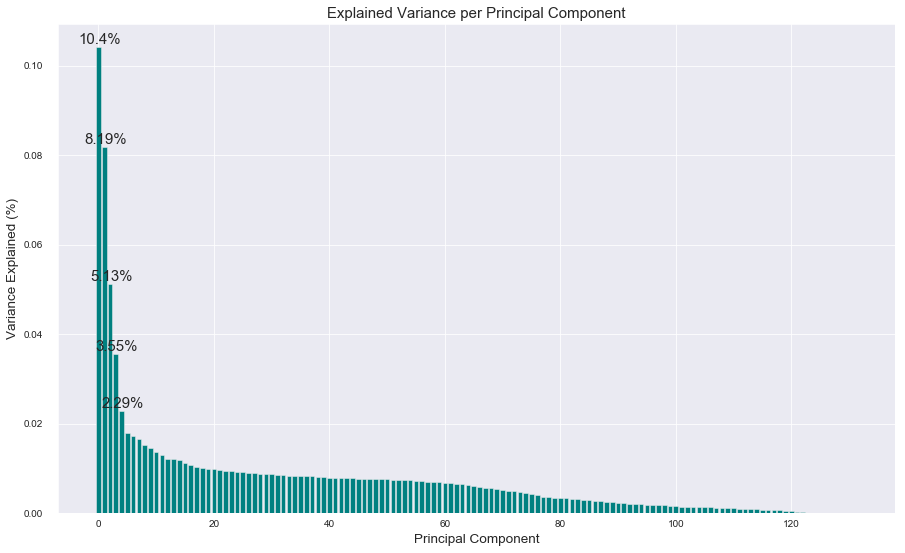

In [101]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: none
    '''
    sns.set_style("darkgrid")
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    plt.style.use("ggplot")
    
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals,color='teal')
    for i in range(0,ind[5]):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2,vals[i]), va='bottom',ha='center',fontsize=15)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1,length=12)
    
    ax.set_xlabel("Principal Component",fontsize=13.5)
    ax.set_ylabel("Variance Explained (%)",fontsize=13.5)
    plt.title("Explained Variance per Principal Component",fontsize=15)
    
    plt.show()
    
    
scree_plot(pca)

[0.1040509  0.18597499 0.23728514 0.27281918 0.29579879 0.31367233
 0.33094913 0.34763317 0.36289875 0.3774116  0.3910322  0.40404706
 0.41629993 0.42848027 0.44040912 0.45159092 0.46236316 0.47262333
 0.48279795 0.49281222 0.5026631  0.51234513 0.52185235 0.53126613
 0.5406157  0.54982346 0.55881912 0.56773308 0.57661416 0.58538938
 0.5941442  0.60273197 0.61121357 0.61967448 0.62811261 0.6364761
 0.64480432 0.65309407 0.66123364 0.66929729 0.67730869 0.68530373
 0.69318781 0.70105374 0.70887573 0.71666228 0.72439956 0.73207041
 0.73971896 0.74734452 0.75493276 0.76246608 0.76992351 0.77735531
 0.78476307 0.79199122 0.79913271 0.8061741  0.81313068 0.82003584
 0.82691768 0.83364946 0.8402872  0.84676185 0.85301853 0.85913988
 0.86513611 0.87080502 0.87637506 0.88181172 0.88705026 0.89209109
 0.89703445 0.90186748 0.90650542 0.91093032 0.9150219  0.91875532
 0.9224229  0.92593064 0.92936402 0.9327213  0.93596516 0.93915253
 0.9421402  0.94510439 0.94790805 0.95066875 0.95328435 0.95573

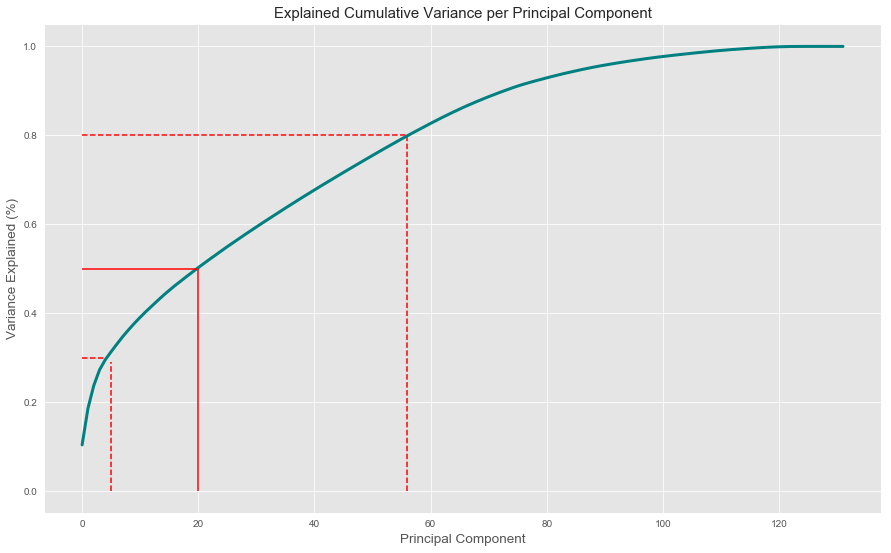

In [102]:
def scree_plot2(pca):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: none
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax.plot(ind, cumvals,color='teal',linewidth=3)
    plt.hlines(y=0.8, xmin=0, xmax=56, color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=56, ymin=0, ymax=0.8, color='red', linestyles='dashed',zorder=2)
    plt.hlines(y=0.3, xmin=0, xmax=4, color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=5, ymin=0, ymax=0.29, color='red', linestyles='dashed',zorder=4)
    plt.hlines(y=0.5, xmin=0, xmax=20, color='red', linestyles='-',zorder=5)
    plt.vlines(x=20, ymin=0, ymax=0.5, color='red', linestyles='-',zorder=6)
    
    ax.set_xlabel("Principal Component",fontsize=13.5)
    ax.set_ylabel("Variance Explained (%)",fontsize=13.5)
    plt.title("Explained Cumulative Variance per Principal Component",fontsize=15)
    
    print(cumvals)
    
scree_plot2(pca)

In [103]:
# Calculate cumulative percentage of variance captured by number of principal components
pca1 = pca.explained_variance_ratio_.tolist()
print(np.sum(pca1[:21]))     

0.5026631010708063


In [196]:
# Re-apply PCA to the data while selecting for number of components to retain.
# 1st Choice based on trying to keep more than 80% of the dataset
pca_2, azdias_3 = do_pca(58,azdias_3)

In [281]:
# 2nd Choice based on simplicity of segment results. The first 5 components make up 30% of the dataset variance
pca_3, azdias_3 = do_pca(5, azdias_3)

In [104]:
# Final choice is halfway house, 21 principal components making up 50% of the dataset variance
pca_4, azdias_3 = do_pca(21, azdias_3)

In [105]:
azdias_3 = pd.DataFrame(azdias_3)
azdias_3[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.304414,-0.925875,-1.116961,0.204963,-0.425961,2.465964,1.262291,-0.241246,0.446339,0.032904,1.761082,-0.280131,0.605772,-0.681340,-0.308572,0.074760,-0.408242,0.947878,-1.012502,3.865606,1.189048
1,-0.031555,-0.171928,-1.214852,1.147381,-1.704994,-0.060155,0.233044,-0.454094,-0.077728,-0.580183,-0.373239,0.800884,0.209295,0.228204,-1.849350,0.018766,1.477833,-0.233477,-0.704225,-0.574683,-0.358264
2,-1.307546,0.378877,-0.484709,-0.967123,-0.091749,-0.838111,-0.053922,0.523721,0.692964,0.368201,0.338603,-0.816995,0.448482,-0.793428,-0.123140,-0.145274,-1.389119,0.687417,-0.136999,-0.844463,-0.537074
3,0.111099,0.215531,1.295413,0.607542,1.475460,0.256833,-1.221206,-2.073223,-1.505420,-0.434483,-1.452622,1.793733,-0.083084,1.081128,-0.682455,0.955416,-0.541346,-0.005659,0.613592,1.551551,-0.457498
4,-0.322190,-0.418193,-0.466283,-1.622011,-1.712219,0.794153,-0.879028,-0.654028,-0.672126,1.786871,1.375171,-0.663491,0.492752,0.958289,0.022306,-0.856158,-0.822250,-0.138070,1.003761,-0.990247,0.204019


### Discussion 2.2: Perform Dimensionality Reduction

Before performing dimensionality reduction we have 132 features in the dataset, cleaned, imputed, scaled and ready to use. After running these 132 features through principal component analysis to obtain a component variance analysis and visualizing them on a scree plot. My initial thought was to lose as little of the dataset variance as possible, which reflected my approach through the data wrangling process, while reducing the number of principal components to be used in the cluster segment analysis. Looking at the "Explained Cumulative Variance per Principal Component", there seemed to be a good trade-off at 58 components. I reduced my features (principal components) from 132 to 58 and maintained 80% of the dataset variance.

But whilst I was sat waiting for the cluster analysis to complete, I started questioning the added-value of this approach, not only did it add time and complexity to the cluster calculations but what value was being obtained from the last 20 or so values which were each adding less than 1% to the overall variance. How would they help with identifying generalised customer segments?

So I went back and I selected the first 5 principal components. This covered only 29.6% of the variance but each principal component added significant variance in percentage terms. This would give relevant clusters in terms of forming generalized customer segment clusters, that would allow easier identification of the important features and correlations and make a clear, concise analysis of the customer segments.

However, I was concerned I was oversimplifying, 30% seemed too low to obtain an accurate analysis! I researched on the internet but found contradictory approaches and opinions, but domain knowledge seems to be most relevant in making the decision of what level of variance loss is acceptable. I do not have the domain knowledge so decided to be a little more conservative in my approach and chose finally a middle-of-the-road approach, keeping 50% of the dataset variance with 21 Principal Components.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [106]:
# Quick look at the composition of the components.
pca_4.components_

array([[-0.11360243,  0.01170421, -0.20579367, ..., -0.11360797,
        -0.12843218,  0.1476437 ],
       [ 0.22381711,  0.04590137,  0.06380848, ..., -0.00717218,
        -0.07309904,  0.06908756],
       [ 0.02145325, -0.34899341,  0.13321696, ..., -0.0128708 ,
        -0.0487909 ,  0.04123344],
       ...,
       [-0.01452372,  0.03046558, -0.0133116 , ..., -0.15649028,
        -0.01066344,  0.03283163],
       [-0.02379158,  0.00489137,  0.03528399, ...,  0.01994528,
        -0.10385237,  0.05712808],
       [ 0.0131413 ,  0.00489112, -0.01404971, ...,  0.05454495,
        -0.03115909,  0.04566559]])

In [107]:
# Quick look at the value of variance explained by each component
pca_4.explained_variance_ratio_

array([0.1040509 , 0.08192409, 0.05131014, 0.03553374, 0.0229783 ,
       0.01785038, 0.01725619, 0.01664676, 0.01523827, 0.014443  ,
       0.01353129, 0.01292463, 0.01215429, 0.01192037, 0.01169014,
       0.01081087, 0.01050974, 0.00984527, 0.00969052, 0.00947647,
       0.00921302])

In [108]:
# Create a dataframe of Explained Variance
dimensions = ['PC {}'.format(i) for i in range(1,len(pca_4.components_)+1)]
ratio = pd.DataFrame(pca_4.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
ratio = ratio.round(4)
ratio.index = dimensions
ratio[:21]

,EXPLAINED_VARIANCE
PC 1,0.1041
PC 2,0.0819
PC 3,0.0513
PC 4,0.0355
PC 5,0.0230
PC 6,0.0179
PC 7,0.0173
PC 8,0.0166
PC 9,0.0152
PC 10,0.0144


In [109]:
# Create a dataframe with the weights for each principal component
weights = pd.DataFrame(pca_4.components_, columns=header_list)
weights = weights.round(4)
weights.index = dimensions
weights[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,GEGEND
PC 1,-0.1136,0.0117,-0.2058,0.1437,-0.1109,0.0753,0.0798,0.1426,-0.1004,0.0391,-0.0245,0.0313,0.0687,0.1058,0.0723,-0.0419,-0.0718,-0.0690,0.0647,0.0920,0.0095,0.0268,0.0386,0.1102,0.0848,-0.0021,0.0294,-0.0748,-0.0052,0.1843,0.0315,-0.0605,0.1152,0.0259,-0.1414,-0.0403,-0.1873,0.0161,0.1195,0.1294,-0.1849,-0.1049,0.1665,-0.1374,-0.0972,0.0389,-0.1976,-0.0350,0.0548,-0.0617,-0.1894,0.1315,0.1907,0.1829,0.0378,-0.1378,0.1221,0.1697,0.1156,-0.0253,-0.0596,0.0233,0.0248,0.0127,0.0207,0.1313,-0.0925,-0.0428,0.0153,-0.0015,-0.0405,-0.0167,-0.0126,-0.0171,0.0073,-0.0311,-0.0320,-0.0462,0.0049,0.0058,-0.0038,0.0289,0.0648,0.0761,-0.0320,0.0090,0.0091,0.0013,0.0005,-0.0097,-0.0225,-0.0018,-0.0385,-0.0436,0.1192,0.1294,0.0115,-0.0275,-0.0119,-0.0264,-0.0136,-0.0162,-0.1144,-0.1124,-0.0787,0.0558,0.0327,-0.0175,0.0007,0.0367,-0.0424,-0.0947,-0.0448,-0.0344,0.0503,0.0881,0.0369,-0.0475,-0.0877,-0.0660,-0.0722,-0.0108,0.0007,0.0335,0.0912,0.1152,-0.1004,0.1067,-0.1836,-0.1136,-0.1284,0.1476
PC 2,0.2238,0.0459,0.0638,-0.2131,0.2095,-0.1991,-0.2087,0.1032,-0.0176,-0.0506,0.1565,-0.0631,-0.1316,-0.2093,-0.1249,-0.0309,0.1559,0.1788,-0.1646,-0.1589,0.0798,0.0363,0.0695,-0.1978,-0.2019,-0.0020,0.0242,-0.0694,0.0063,0.0604,0.1177,0.0488,0.0617,0.0284,-0.0710,-0.0250,-0.0772,-0.0008,0.0490,0.0696,-0.0890,-0.0597,0.0934,-0.0743,-0.0449,0.0017,-0.0842,-0.1639,0.0138,-0.0343,-0.0934,0.0670,0.0958,0.0900,0.0146,-0.0719,0.0695,0.0936,0.0662,0.0680,0.1015,-0.0322,-0.0534,-0.0347,-0.0397,-0.1187,0.0797,-0.0789,-0.0905,0.0997,0.0635,-0.0246,-0.0436,0.0282,0.0602,0.0196,0.0143,0.0354,0.0237,-0.0711,0.0075,-0.0104,-0.0326,0.0602,0.0298,-0.0215,-0.0262,-0.0231,-0.0334,-0.0402,-0.0369,-0.0095,-0.0250,-0.0388,0.1154,-0.0810,0.0544,-0.0278,-0.0831,-0.0123,0.0086,-0.0233,-0.0227,-0.0050,0.0579,-0.0367,-0.0450,-0.0563,-0.0251,0.0092,0.0739,-0.0743,-0.0365,0.1989,-0.1000,-0.0833,0.0275,-0.0083,-0.0381,-0.0303,-0.0440,-0.0067,0.0125,0.0149,0.0490,0.0350,-0.0176,-0.2209,-0.0814,-0.0072,-0.0731,0.0691
PC 

In [110]:
# Combine the 2 dataframes
result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
result[:3]

,EXPLAINED_VARIANCE,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,GEGEND
PC 1,0.1041,-0.1136,0.0117,-0.2058,0.1437,-0.1109,0.0753,0.0798,0.1426,-0.1004,0.0391,-0.0245,0.0313,0.0687,0.1058,0.0723,-0.0419,-0.0718,-0.0690,0.0647,0.0920,0.0095,0.0268,0.0386,0.1102,0.0848,-0.0021,0.0294,-0.0748,-0.0052,0.1843,0.0315,-0.0605,0.1152,0.0259,-0.1414,-0.0403,-0.1873,0.0161,0.1195,0.1294,-0.1849,-0.1049,0.1665,-0.1374,-0.0972,0.0389,-0.1976,-0.0350,0.0548,-0.0617,-0.1894,0.1315,0.1907,0.1829,0.0378,-0.1378,0.1221,0.1697,0.1156,-0.0253,-0.0596,0.0233,0.0248,0.0127,0.0207,0.1313,-0.0925,-0.0428,0.0153,-0.0015,-0.0405,-0.0167,-0.0126,-0.0171,0.0073,-0.0311,-0.0320,-0.0462,0.0049,0.0058,-0.0038,0.0289,0.0648,0.0761,-0.0320,0.0090,0.0091,0.0013,0.0005,-0.0097,-0.0225,-0.0018,-0.0385,-0.0436,0.1192,0.1294,0.0115,-0.0275,-0.0119,-0.0264,-0.0136,-0.0162,-0.1144,-0.1124,-0.0787,0.0558,0.0327,-0.0175,0.0007,0.0367,-0.0424,-0.0947,-0.0448,-0.0344,0.0503,0.0881,0.0369,-0.0475,-0.0877,-0.0660,-0.0722,-0.0108,0.0007,0.0335,0.0912,0.1152,-0.1004,0.1067,-0.1836,-0.1136,-0.1284,0.1476
PC 2,0.0819,0.2238,0.0459,0.0638,-0.2131,0.2095,-0.1991,-0.2087,0.1032,-0.0176,-0.0506,0.1565,-0.0631,-0.1316,-0.2093,-0.1249,-0.0309,0.1559,0.1788,-0.1646,-0.1589,0.0798,0.0363,0.0695,-0.1978,-0.2019,-0.0020,0.0242,-0.0694,0.0063,0.0604,0.1177,0.0488,0.0617,0.0284,-0.0710,-0.0250,-0.0772,-0.0008,0.0490,0.0696,-0.0890,-0.0597,0.0934,-0.0743,-0.0449,0.0017,-0.0842,-0.1639,0.0138,-0.0343,-0.0934,0.0670,0.0958,0.0900,0.0146,-0.0719,0.0695,0.0936,0.0662,0.0680,0.1015,-0.0322,-0.0534,-0.0347,-0.0397,-0.1187,0.0797,-0.0789,-0.0905,0.0997,0.0635,-0.0246,-0.0436,0.0282,0.0602,0.0196,0.0143,0.0354,0.0237,-0.0711,0.0075,-0.0104,-0.0326,0.0602,0.0298,-0.0215,-0.0262,-0.0231,-0.0334,-0.0402,-0.0369,-0.0095,-0.0250,-0.0388,0.1154,-0.0810,0.0544,-0.0278,-0.0831,-0.0123,0.0086,-0.0233,-0.0227,-0.0050,0.0579,-0.0367,-0.0450,-0.0563,-0.0251,0.0092,0.0739,-0.0743,-0.0365,0.1989,-0.1000,-0.0833,0.0275,-0.0083,-0.0381,-0.0303,-0.0440,-0.0067,0.0125,0.0149,0.0490,0.0350,-0.0176,-0.2209,-

In [111]:
# Function integrating the steps above to be used in later analysis
def show_pca_weights(principal_component,no_of_weights):
    
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca_4.components_)+1)]
    
    ratio = pd.DataFrame(pca_4.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(4)
    ratio.index = dimensions
    
    weights = pd.DataFrame(pca_4.components_, columns=header_list)
    weights = weights.round(4)
    weights.index = dimensions
    
    result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
    result[:5]
    print("Principal Component", (principal_component))
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values(ascending=False)[:no_of_weights])
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values()[:no_of_weights])

In [112]:
# Analysis of the highest positive and negative weights for the first Principal Componnent
show_pca_weights(1,5)

Principal Component 1
------------------------------
PLZ8_ANTG3            0.1907
HH_EINKOMMEN_SCORE    0.1843
PLZ8_ANTG4            0.1829
ORTSGR_KLS9           0.1697
EWDICHTE              0.1665
Name: PC 1, dtype: float64
------------------------------
FINANZ_MINIMALIST   -0.2058
MOBI_REGIO          -0.1976
PLZ8_ANTG1          -0.1894
KBA05_ANTG1         -0.1873
KBA05_GBZ           -0.1849
Name: PC 1, dtype: float64


In [113]:
# Analysis of the highest positive and negative weights for the second Principal Componnent
show_pca_weights(2,5)

Principal Component 2
------------------------------
ALTERSKATEGORIE_GROB    0.2238
FINANZ_VORSORGER        0.2095
ZABEOTYP_3              0.1989
SEMIO_ERL               0.1788
RETOURTYP_BK_S          0.1565
Name: PC 2, dtype: float64
------------------------------
DEKADE                  -0.2209
FINANZ_SPARER           -0.2131
SEMIO_REL               -0.2093
FINANZ_UNAUFFAELLIGER   -0.2087
SEMIO_TRADV             -0.2019
Name: PC 2, dtype: float64


In [114]:
# Analysis of the highest positive and negative weights for the third Principal Componnent
show_pca_weights(3,5)

Principal Component 3
------------------------------
SEMIO_VERT     0.3241
SEMIO_FAM      0.2602
SEMIO_SOZ      0.2584
SEMIO_KULT     0.2503
FINANZTYP_5    0.1376
Name: PC 3, dtype: float64
------------------------------
ANREDE_KZ    -0.3490
SEMIO_KAEM   -0.3187
SEMIO_DOM    -0.2869
SEMIO_KRIT   -0.2677
SEMIO_ERL    -0.2048
Name: PC 3, dtype: float64


In [115]:
# Save checkpoint
azdias_3.to_csv('azdias_checkpoint_3.csv',sep=';',encoding='utf-8',index=False)

### Discussion 2.3: Interpret Principal Components


The first 5 principal components make up 29.6% of the total variance of the dataset. The first component makes up 10.4% of the total variance.

Each component is a combination of the 132 features left after cleaning, with each feature given a weight relative to its importance for a particular principal component. The higher the weight either positive or negative, the more impact the feature has on the calculation of the principal component. What value of weight is important is subjective and depends on the context.

I have taken the 5 highest weights positive and negative to interpret the first 3 principal components, this is an arbitrary decision and I could easily have extended this to 6 or reduced it to only 4 as the weight ratios are close to each other in numeric value.

For component 1 the top 5 positive weights are: "PLZ8_ANTG3", number of 6-10 family homes in the PLZ8 region, "HH_EINKOMMEN_SCORE", Estimated household net income, "PLZ8_ANTG4", number of 10+ family houses in the PLZ8 region, "ORTSGR_KLS9", size of community, "EWDICHTE", density of households per km squared.

The top 5 negative weights are: "FINANZ_MINIMALIST", low financial interest, "MOBI_REGIO", movement patterns, "PLZ8_ANTG1", number of 1-2 family houses in PLZ8 region, "KBA05_ANTG1" number of 1-2 family houses in the microcell,  "KBA05_GBZ", number of buildings in the microcell.

The first principal component seems to be representing a combination of features that relate to population density in an area and the associated wealth of that area. Positive correlations with increasing population density and wealth and negative correlations with low density and little financial interest features.

For component 2 the top 5 positive weights: "ALTERSKATEGORIE_GROB", estimated age based on given name analysis, "FINANZ_VORSORGER", financial typology is be prepared, "ZABEOTYP_3", energy consumption typology, "SEMIO_ERL", personality typology event-oriented, "RETOURTYP_BK_S", return shopper type.

And top 5 negative weights: "DEKADE", decade of youth, "FINANZ_SPARER", financial typology is money-saver, "SEMIO_REL", personality typology is religious, "FINANZ_UNAUFFAELLIGER", financial typology is inconspicuous, "SEMIO_TRADV", personality typology is traditional-minded.

The second principal component seems to be representing a combination of features related to individuals of older people with conservative traditional values. Positive correlations with increasing age and financial prudence.

For component 3, I have taken only the first 4 positive features as the fifth as a weight conspicuously lower than the fourth at 14% to 25%. The top weight "SEMIO_VERT", personality type dreamful, is also 6% higher than the second weight "SEMIO_FAM", personality type is family-minded, "SEMIO_SOZ", personality type is socially-minded, and "SEMIO_KULT", personality type is cultural-minded.

And the top 5 negative weights: "ANREDE_KZ" gender at -35%, "SEMIO_KAEM", personality typology is combative attitude, "SEMIO_DOM", personality typology is dominant-minded, "SEMIO_KRIT", personality typology is critical-minded, "SEMIO_ERL", personality typology is event-orientated.

Finally, the third principal component seems to be representing a combination of features related to individuals of female gender with a humanitarian disposition.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [116]:
# Load last checkpoint
azdias_4 = pd.read_csv('azdias_checkpoint_3.csv',sep=';')
azdias_4[:1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.304414,-0.925875,-1.116961,0.204963,-0.425961,2.465964,1.262291,-0.241246,0.446339,0.032904,1.761082,-0.280131,0.605772,-0.68134,-0.308572,0.07476,-0.408242,0.947878,-1.012502,3.865606,1.189048


In [117]:
# Function to calculate K-Means score for a centroid

def get_kmeans_score(data, center):
    
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score
    

In [118]:
# Run possible number of cluster centroid through K-means score function
score = []
centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

for x in centroids:
    score.append(get_kmeans_score(azdias_4,x))

In [119]:
# Create dataframe showing the average point-centroid distances
score_ds = pd.Series(score)
centroids_ds = pd.Series(centroids)
score_df = pd.concat([centroids_ds,score_ds],axis=1)
score_df.columns = ['clusters','average_distance']
score_df.set_index('clusters',inplace=True)
score_df['average_distance'] = score_df['average_distance'].round(0)
score_df[:17]

,average_distance
clusters,
2,15565609.0
4,14503793.0
6,13582568.0
7,13216674.0
8,12956609.0
9,12665125.0
10,12419300.0
11,12203211.0
12,11966815.0


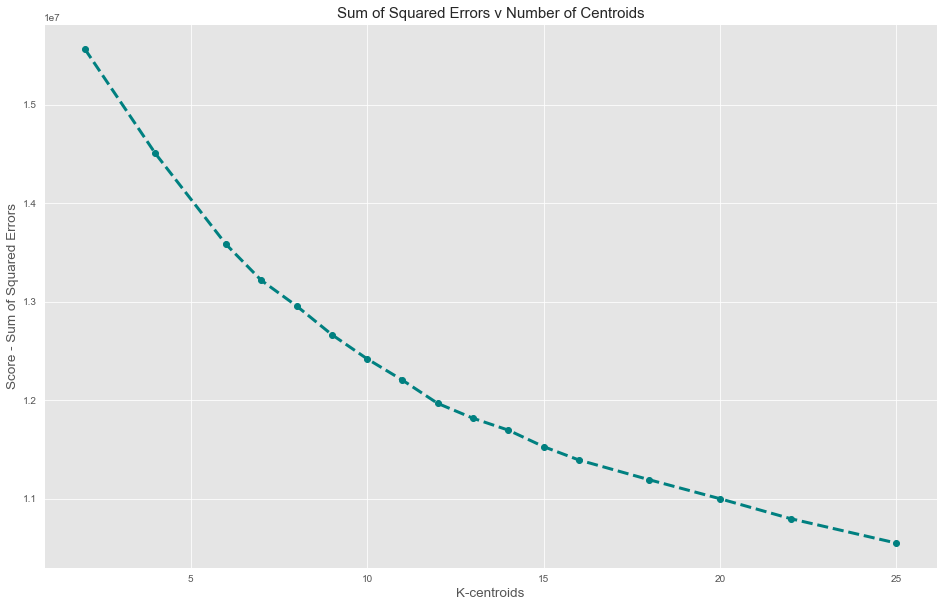

In [122]:
# Investigate the change in within-cluster distance across number of clusters.

fig = plt.subplots(figsize=(16,10))
ax = plt.subplot(111)
plt.plot(centroids,score,linestyle='--',linewidth=3,marker='o',color='teal')

ax.set_xlabel('K-centroids', fontsize=13.5)
ax.set_ylabel('Score - Sum of Squared Errors', fontsize=13.5)
plt.title('Sum of Squared Errors v Number of Centroids',fontsize=15);



In [123]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_10 = KMeans(n_clusters=10, n_init=10, max_iter=300, random_state=42)
population_clusters = kmeans_10.fit_predict(azdias_4)


### Discussion 3.1: Apply Clustering to General Population

The first run of K-Means with 58 principal components resulted in almost a straight line with little definition of an "elbow". Running the K-Means algorithm the second time with only 5 principal components gave me a better defined "elbow" and a clear cluster value of 8 clusters.

However, my final choice of 21 principal components resulted in the plot and table you see above. There is an "elbow", but it is much less defined than with 5 principal components. Possible cluster candidates are 6, 7, 10, 12, and 15 depending if you take a high "elbow" at 6 clusters or low "elbow" at 15 clusters. Again from research on the internet, there doesn't seem to be an agreement on a "correct" location to decide the number of clusters, knowledge of the domain is useful. I also noticed that changing the plotsize and changing the height and width dimensions of the plot affected the perception of where was the best "elbow".

I ran all the clusters mentioned above through the population and customer datasets to be able to make comparisons on the effects of selecting a different number of clusters. In general, the lower number of clusters gave more equal distribution in the population clustering of the dataset, there was less extremes between the clusters, whereas a higher number of clusters resulted in the population clustering having some wide differences between counts allocated to clusters. The customer distribution varied according to the number of clusters.

Once again, due to my inexperience with these techniques, I went for a 'middle' solution and chose 10 clusters which seems to reflect the mid-point in the bend of the "elbow".


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [124]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [125]:
# View shape of customer dataset
customers.shape

(191652, 85)

In [126]:
# Quick check of customer dataframe
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [127]:
# Apply population data wrangling to customer dataframe
customers_clean = clean_data(customers)

In [128]:
# Check the shape to see cleaning taken place
customers_clean.shape

(136159, 132)

In [129]:
# Quick check of cleaned dataframe
customers_clean[:10]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DEKADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,GEGEND
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1.0,2.0,5.0,3.0,1,0
2,4.0,2,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1.0,2.0,3.0,4.0,0,2
3,4.0,1,5,1,5,2,1,2,0,2.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,4.0,4.0,1,0
4,3.0,1,3,1,4,4,5,2,0,3.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,4.0,2.0,1.0,0,3
5,3.0,1,5,1,5,1,2,3,1,3.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,2.0,3.0,4.0,0,1
6,4.0,1,5,1,5,1,1,2,1,2.0,5.0,4,2,5,1,6,5,3,4,3,3,1,2,2,4,0.0,1.0,2.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1,4.0,1.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,5.0,5.0,2.0,3.0,2.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [130]:
customer_header_list = list(customers_clean.columns.values)
customer_header_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'CJT_GESAMTTYP_1.0',
 'CJT_GESAMTT

In [131]:
# Check for null values
customers_clean.isnull().any().sum()

32

In [132]:
# Use population imputer to transform customer dataframe
customers_clean = imputer.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,3.0,1.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0,2.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,4.0,6.0,9.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,1.0,0.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,3.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0


In [133]:
# Check no null values remain
customers_clean.isnull().any().sum()

0

In [134]:
# Apply population scaler to transform customer dataframe
customers_clean = scaler.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131
0,1.180995,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.818216,1.882757,-1.637628,1.069967,0.948521,0.466775,-1.041304,1.112635,0.894811,1.260213,-0.889100,-0.072194,-1.744309,-0.878225,-1.953454,-1.761688,-1.167273,-1.545041,-0.09194,-1.089955,0.229518,-0.060656,-2.231523,0.955468,0.55372,-0.47079,-0.1257,1.282420,0.519166,0.393000,0.621253,-0.603458,-0.469941,0.648130,-0.525099,-1.135351,-0.266472,0.287782,-1.842159,0.759398,0.180081,-1.976937,1.674311,0.775287,0.213141,-0.611353,-0.953065,1.435587,1.467394,-2.187068,-1.439172,-1.533403,-0.365261,-0.468594,-0.476736,-0.576502,2.475441,-0.381946,-0.57218,2.574427,-0.228256,-0.275565,-0.393436,-0.763261,-0.262746,-0.231852,-0.270379,3.449096,-0.314473,-0.184237,-0.233064,-0.343491,-0.277882,-0.387341,-0.324358,-0.438917,-1.018157,2.657870,-0.075533,-0.121316,-0.119845,-0.10054,-0.157102,-0.168138,-0.115951,-0.442932,-0.257546,-0.599220,-0.405152,-0.310996,-0.322773,-0.187038,-0.194341,-0.108601,-0.144858,-0.450771,2.468524,0.437894,-0.295495,-0.20626,-0.439511,-0.669121,-0.595644,1.862182,-0.425547,-0.202728,1.348673,-0.594162,-0.337329,-0.313275,4.571814,-0.340607,-0.345596,-0.386270,-0.271057,-0.392968,-0.330435,-0.454342,-0.39952,1.882757,-1.624552,1.556065,0.092492,1.811996,-1.471874
1,1.180995,0.958422,1.415239,-1.151076,1.133590,-1.247929,0.981043,0.612067,1.882757,-0.315096,1.069967,-1.110313,-1.104745,-1.565068,-0.454567,-0.653239,1.260213,1.299560,-1.604228,-1.140061,1.408286,0.239132,0.911448,-0.098129,-1.545041,-0.09194,0.917469,-0.633695,-0.060656,-2.231523,0.955468,0.55372,-0.47079,-0.1257,-1.299512,0.519166,0.393000,0.621253,-0.603458,-0.469941,-0.115972,1.304788,0.028541,-1.744393,-0.797041,0.269658,0.068420,-1.105842,1.334151,-0.555345,-0.258072,0.213141,1.423822,0.422301,-0.625000,-1.243313,-0.179238,-0.132956,-0.058229,-0.365261,2.134046,-0.476736,-0.576502,-0.403968,-0.381946,-0.57218,2.574427,-0.228256,-0.275565,-0.393436,-0.763261,-0.262746,-0.231852,3.698513,-0.289931,-0.314473,-0.184237,-0.233064,-0.343491,-0.277882,-0.387341,-0.324358,-0.438917,0.982167,-0.376241,-0.075533,-0.121316,-0.119845,-0.10054,-0.157102,-0.168138,-0.115951,-0.442932,-0.257546,-0.599220,-0.405152,-0.310996,-0.322773,-0.187038,-0.194341,-0.108601,-0.144858,-0.450771,2.468524,0.437894,-0.295495,-0.20626,-0.439511,1.494498,-0.595644,-0.537005,-0.425547,-0.202728,1.348673,-0.594162,-0.337329,-0.313275,-0.218732,-0.340607,-0.345596,-0.386270,3.689258,-0.392968,-0.330435,-0.454342,-0.39952,1.882757,-1.624552,0.192596,0.763676,-0.551878,-0.250165
2,1.180995,-1.043381,1.415239,-1.151076,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,-0.303125,0.948521,0.466775,-0.517541,0.067833,1.410828,0.308392,-0.889100,-0.072194,-0.535813,-0.878225,-0.857161,-0.692434,-0.632701,0.155553,-0.09194,-1.089955,-1.496909,-0.060656,-0.285966,0.955468,0.55372,-0.47079,-0.1257,-0.654029,0.519166,1.103886,-0.984229,-0.603458,-0.469941,0.648130,1.304788,-1.717297,1.211449,0.287782,0.269658,0.759398,-0.462880,0.782303,0.379485,0.775287,-0.878495,-0.611353,-0.953065,-0.625000,0.563825,-2.187068,-1.003767,-1.533403,-0.365261,2.134046,-0.476736,-0.576502,-0.403968,-0.381946,-0.57218,-0.388436,-0.228256,-0.275565,-0.393436,1.310167,-0.262746,-0.231852,-0.270379,-0.289931,-0.314473,-0.184237,-0.233064,-0.343491,-0.277882,2.581701,-0.324358,-0.438917,-1.018157,-0.376241,-0.075533,-0.121316,-0.119845,-0.10054,-0.157102,-0.168138,-0.115951,-0.442932,-0.257546,-0.599220,-0.405152,-0.310996,-0.322773,-0.187038,-0.194341,-0.108601,-0.144858,2.218421,-0.405100,0.437894,-0.295495,-0.206

In [135]:
# Apply population Principal Component transformation on customer dataframe
customers_clean = pca_4.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-1.871456,0.448500,1.399254,0.742832,-1.816663,1.935193,1.083148,-0.205986,-0.143574,-0.245839,0.171730,-0.546185,-0.705598,-0.618963,0.643056,-0.732674,-0.028256,-0.211582,-0.608105,-0.301547,0.897548
1,-0.677415,1.550616,-0.448829,1.204662,-1.024839,-1.005387,0.392948,-0.649922,0.951145,0.095721,-0.842711,-0.011758,0.184536,-1.696154,0.878693,-0.262227,-0.821383,0.107886,-0.213623,-0.382863,-1.793004
2,-1.513634,-0.017645,0.949022,-1.659739,-0.184422,0.355170,0.196610,0.326375,0.582620,1.035865,0.330635,-0.603733,0.363839,0.588390,-1.012935,-0.919946,-1.177001,-0.641290,-0.387920,0.310101,-0.515140
3,0.273662,-0.217970,0.624484,0.064498,1.342622,0.944422,-1.359194,-0.024351,-0.778969,0.051110,-1.875779,-1.378908,1.202672,-1.482231,-0.265112,0.504402,-0.343815,0.108445,0.144561,-1.015844,0.308822
4,-0.747583,0.366984,1.240264,1.564801,-0.954371,0.725636,-0.347806,0.750197,-1.395063,-0.427168,0.510432,1.340943,4.190848,0.825029,2.603082,0.027371,0.532418,-1.219257,-0.538095,0.675829,0.318175


In [136]:
# Apply K-means clustering prediction using fitted algorithm from population
customer_clusters = kmeans_10.predict(customers_clean)

In [137]:
# Obtain missing row data for customer dataset
missing_row_data_2 = customers.isnull().sum(axis=1)
customer_rows_deleted = customers[customers.index.isin(missing_row_data_2[missing_row_data_2 > 9].index)]
customer_rows_deleted[:4]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,NaN,1.0,3,11.0,3.0,0.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,NaN,1.0,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
10,NaN,3.0,2,5.0,4,2,4,4,3,1,6,1960.0,11.0,0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,4.0,4,1,1,2,4,4,6,1,4,7,6,7,4,3,3.0,0.0,NaN,1.0,3,14.0,1.0,0.0,NaN,1.0,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,4.0,1,6.0,5,3,4,2,3,1,3,1965.0,10.0,1,1.0,28.0,8.0,8.0,4.0,10.0,5.0,1.0,11.0,3.0,3,4,2,6,7,7,7,4,1,3,3,4,4,1,3.0,0.0,NaN,1.0,1,NaN,3.0,0.0,2.0,1.0,6.0,9.0,1.0,0.0,1.0,4.0,1994.0,W,2.0,5,5C,33,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,4.0,3.0,NaN,5.0,7.0,410.0,4.0,1.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,5.0


In [138]:
customer_rows_deleted.shape

(61179, 85)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [139]:
# Count number of predictions for each customer segment
customer_clusters = pd.Series(customer_clusters)
cc = customer_clusters.value_counts().sort_index()
cc = pd.Series(cc)
cc

0    31471
1    23934
2     1948
3     4998
4     4581
5      892
6     1086
7    56031
8     8487
9     2731
dtype: int64

In [140]:
# Count number in each population segment
population_clusters = pd.Series(population_clusters)
pc = population_clusters.value_counts().sort_index()
pc = pd.Series(pc)
pc

0    116982
1    153504
2     61099
3     72030
4     46710
5     21902
6    102632
7    107764
8     88879
9      3241
dtype: int64

In [141]:
# Create a dataframe from population and customer segments
final_df = pd.concat([pc, cc], axis=1).reset_index()
final_df.columns = ['cluster','population','customer']
final_df

,cluster,population,customer
0,0,116982,31471
1,1,153504,23934
2,2,61099,1948
3,3,72030,4998
4,4,46710,4581
5,5,21902,892
6,6,102632,1086
7,7,107764,56031
8,8,88879,8487
9,9,3241,2731


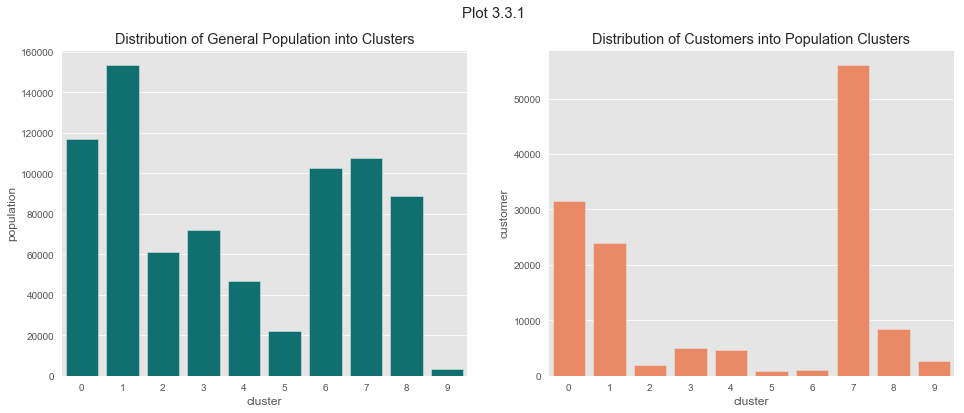

In [142]:
# Visualize dataframe as bar charts
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='cluster',y='population',color='teal',edgecolor='.9',data=final_df)
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='cluster',y='customer',color='coral',edgecolor='.9',data=final_df)
plt.title("Distribution of Customers into Population Clusters")
plt.suptitle("Plot 3.3.1", fontsize=15);

In [143]:
# Add ratio and ratio difference for each cluster to the dataframe
final_df['pop_%'] = (final_df['population']/final_df['population'].sum()*100).round(2)
final_df['cust_%'] = (final_df['customer']/final_df['customer'].sum()*100).round(2)
final_df['diff'] = final_df['cust_%'] - final_df['pop_%']
final_df

,cluster,population,customer,pop_%,cust_%,diff
0,0,116982,31471,15.10,23.11,8.01
1,1,153504,23934,19.81,17.58,-2.23
2,2,61099,1948,7.89,1.43,-6.46
3,3,72030,4998,9.30,3.67,-5.63
4,4,46710,4581,6.03,3.36,-2.67
5,5,21902,892,2.83,0.66,-2.17
6,6,102632,1086,13.25,0.80,-12.45
7,7,107764,56031,13.91,41.15,27.24
8,8,88879,8487,11.47,6.23,-5.24
9,9,3241,2731,0.42,2.01,1.59


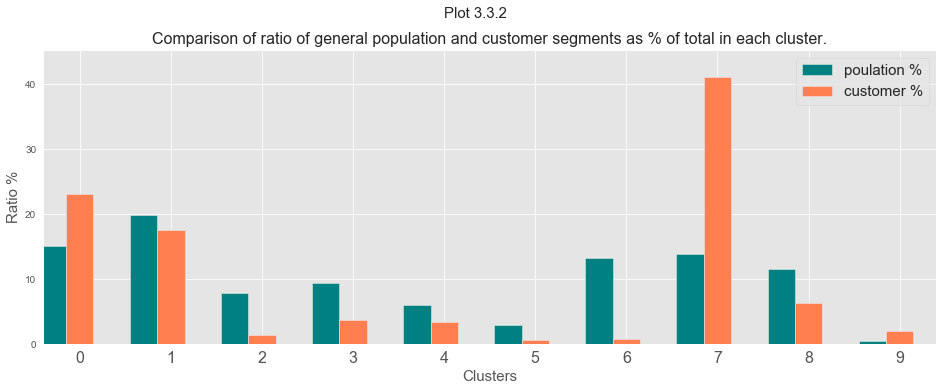

In [144]:
# Visualize ratios for each cluster

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = final_df['pop_%'].plot(x=final_df['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = final_df['cust_%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer segments as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot 3.3.2", fontsize=15)
plt.show()

In [145]:
# Missing rows from population dataset
population_rows_deleted = azdias_subset_2.shape[0]
population_rows_deleted

116478

In [146]:
# Missing rows from customer dataset
customer_rows_deleted = customer_rows_deleted.shape[0]
customer_rows_deleted

61179

In [147]:
# Add missing data rows as an extra cluster to dataframe
final_df.loc[-1] = ['-1', population_rows_deleted, customer_rows_deleted,0,0,0]  # adding a row
final_df.index = final_df.index + 1  # shifting index
final_df.sort_index(inplace=True)


In [148]:
# Recalculate ratios and differences
final_df['pop_%'] = (final_df['population']/final_df['population'].sum()*100).round(2)
final_df['cust_%'] = (final_df['customer']/final_df['customer'].sum()*100).round(2)
final_df['diff'] = final_df['cust_%'] - final_df['pop_%']
final_df

,cluster,population,customer,pop_%,cust_%,diff
0,-1,116478,61179,13.07,31.00,17.93
1,0,116982,31471,13.13,15.95,2.82
2,1,153504,23934,17.22,12.13,-5.09
3,2,61099,1948,6.86,0.99,-5.87
4,3,72030,4998,8.08,2.53,-5.55
5,4,46710,4581,5.24,2.32,-2.92
6,5,21902,892,2.46,0.45,-2.01
7,6,102632,1086,11.52,0.55,-10.97
8,7,107764,56031,12.09,28.39,16.30
9,8,88879,8487,9.97,4.30,-5.67


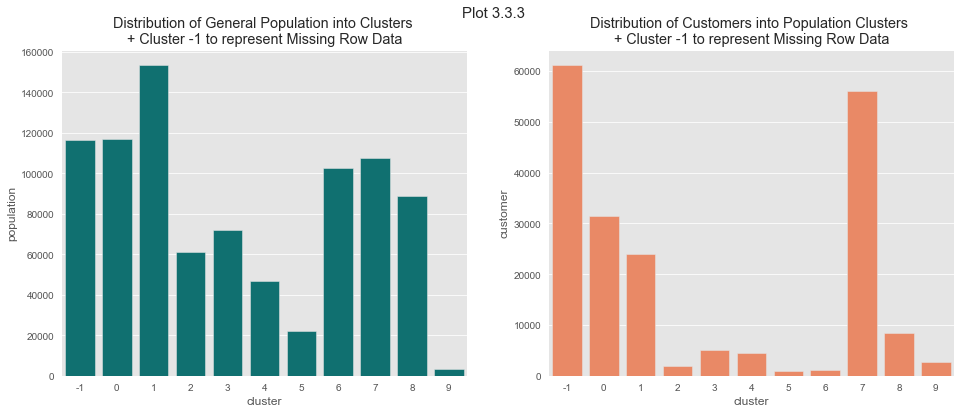

In [149]:
# Re-visualize plot with missing row data added as cluster -1

fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x=final_df['cluster'],y=final_df['population'],color='teal',edgecolor='.9',data=final_df)
plt.title("Distribution of General Population into Clusters \n+ Cluster -1 to represent Missing Row Data")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x=final_df['cluster'],y=final_df['customer'],color='coral',edgecolor='.9',data=final_df)
plt.title("Distribution of Customers into Population Clusters \n+ Cluster -1 to represent Missing Row Data")
plt.suptitle("Plot 3.3.3", fontsize=15);

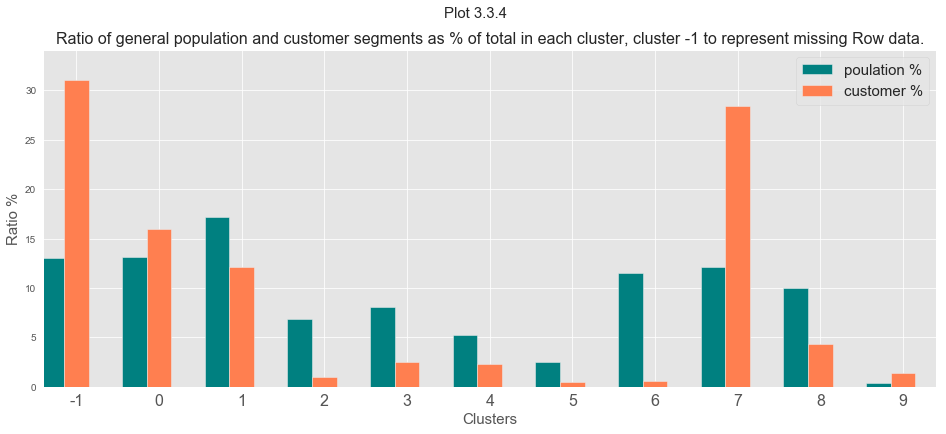

In [150]:
# Re-visualize cluster rations with missing row cluster -1

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx()

ax = final_df['pop_%'].plot(x=final_df['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = final_df['cust_%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[-1,0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Ratio of general population and customer segments as % of total in each cluster, cluster -1 to represent missing Row data.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.1)
plt.suptitle("Plot 3.3.4", fontsize=15)
plt.show()

In [151]:
# Analysis of principal components of cluster 7 with over-representation in customer segment.
cc0 = kmeans_10.cluster_centers_[7]
cc0 = pd.Series(cc0)
cc0.index = cc0.index +1
cc0.sort_values(ascending=False)

4     1.354791
11    0.599870
17    0.396377
3     0.352003
7     0.180170
9     0.159497
2     0.048610
15    0.033414
10    0.010969
21   -0.071991
12   -0.103382
8    -0.131587
19   -0.135244
5    -0.136296
13   -0.215900
6    -0.253719
20   -0.265762
18   -0.280792
16   -0.410954
14   -0.543810
1    -1.062108
dtype: float64

In [152]:
# Transform cluster 7 to original feature values.
cc00 = scaler.inverse_transform(pca_4.inverse_transform(cc0))
cc00 = pd.Series(cc00).round(2)
cc00.index = header_list
cc00

ALTERSKATEGORIE_GROB       3.20
ANREDE_KZ                  1.46
FINANZ_MINIMALIST          4.46
FINANZ_SPARER              1.85
FINANZ_VORSORGER           4.03
FINANZ_ANLEGER             2.00
FINANZ_UNAUFFAELLIGER      2.28
FINANZ_HAUSBAUER           2.04
GREEN_AVANTGARDE           0.98
HEALTH_TYP                 2.10
RETOURTYP_BK_S             3.60
SEMIO_SOZ                  4.26
SEMIO_FAM                  3.68
SEMIO_REL                  3.21
SEMIO_MAT                  3.34
SEMIO_VERT                 4.81
SEMIO_LUST                 4.97
SEMIO_ERL                  4.93
SEMIO_KULT                 3.73
SEMIO_RAT                  3.28
SEMIO_KRIT                 4.19
SEMIO_DOM                  4.58
SEMIO_KAEM                 4.08
SEMIO_PFLICHT              3.36
SEMIO_TRADV                3.21
SOHO_KZ                    0.01
VERS_TYP                   1.49
ANZ_PERSONEN               2.30
ANZ_TITEL                  0.00
HH_EINKOMMEN_SCORE         2.30
W_KEIT_KIND_HH             4.07
WOHNDAUE

In [153]:
# Analyze top principal component in cluster 7
show_pca_weights(4,5)

Principal Component 4
------------------------------
AVANTGARDE             0.3254
GREEN_AVANTGARDE       0.3254
LP_STATUS_FEIN_10.0    0.2500
EWDICHTE               0.2262
ORTSGR_KLS9            0.2262
Name: PC 4, dtype: float64
------------------------------
RURAL                -0.2219
HH_EINKOMMEN_SCORE   -0.1998
BALLRAUM             -0.1842
INNENSTADT           -0.1772
LP_STATUS_FEIN_4.0   -0.1769
Name: PC 4, dtype: float64


In [154]:
# Analyze second top principal component in cluster 7
show_pca_weights(11,5)

Principal Component 11
------------------------------
FINANZTYP_6            0.3811
PLZ8_HHZ               0.3050
KBA13_ANZAHL_PKW       0.2608
PLZ8_GBZ               0.1841
LP_STATUS_FEIN_10.0    0.1678
Name: PC 11, dtype: float64
------------------------------
OST_WEST_KZ             -0.2724
FINANZTYP_5             -0.2282
FINANZ_UNAUFFAELLIGER   -0.1815
LP_STATUS_FEIN_3.0      -0.1615
ZABEOTYP_4              -0.1389
Name: PC 11, dtype: float64


In [155]:
# Analysis of principal components of cluster 6 with under-representation in customer segment.
customer_under_rep = kmeans_10.cluster_centers_[6]
customer_under_rep = pd.Series(customer_under_rep)
customer_under_rep.index = customer_under_rep.index +1
customer_under_rep.sort_values(ascending=False)

1     1.188396
7     0.350769
11    0.266166
9     0.188913
10    0.158104
6     0.108784
15    0.099720
13    0.072991
14    0.010544
12   -0.026611
4    -0.033342
20   -0.111838
21   -0.135569
18   -0.153995
17   -0.310962
16   -0.379201
5    -0.388263
3    -0.394588
19   -0.589963
2    -0.724172
8    -0.835961
dtype: float64

In [156]:
# Transform cluster 7 to original feature values.
customer_under_rep_features = scaler.inverse_transform(pca_4.inverse_transform(customer_under_rep))
customer_under_rep_features = pd.Series(customer_under_rep_features).round(2)
customer_under_rep_features.index = header_list
customer_under_rep_features

ALTERSKATEGORIE_GROB       1.69
ANREDE_KZ                  1.68
FINANZ_MINIMALIST          1.19
FINANZ_SPARER              4.64
FINANZ_VORSORGER           2.18
FINANZ_ANLEGER             4.45
FINANZ_UNAUFFAELLIGER      4.02
FINANZ_HAUSBAUER           4.26
GREEN_AVANTGARDE           0.09
HEALTH_TYP                 2.35
RETOURTYP_BK_S             2.39
SEMIO_SOZ                  4.33
SEMIO_FAM                  4.76
SEMIO_REL                  5.73
SEMIO_MAT                  4.43
SEMIO_VERT                 3.37
SEMIO_LUST                 2.99
SEMIO_ERL                  3.48
SEMIO_KULT                 4.92
SEMIO_RAT                  5.35
SEMIO_KRIT                 4.46
SEMIO_DOM                  4.89
SEMIO_KAEM                 4.76
SEMIO_PFLICHT              5.99
SEMIO_TRADV                5.13
SOHO_KZ                    0.01
VERS_TYP                   1.62
ANZ_PERSONEN               1.37
ANZ_TITEL                  0.00
HH_EINKOMMEN_SCORE         5.47
W_KEIT_KIND_HH             4.68
WOHNDAUE

In [157]:
# Analyze top principal component in cluster 6
show_pca_weights(1,5)

Principal Component 1
------------------------------
PLZ8_ANTG3            0.1907
HH_EINKOMMEN_SCORE    0.1843
PLZ8_ANTG4            0.1829
ORTSGR_KLS9           0.1697
EWDICHTE              0.1665
Name: PC 1, dtype: float64
------------------------------
FINANZ_MINIMALIST   -0.2058
MOBI_REGIO          -0.1976
PLZ8_ANTG1          -0.1894
KBA05_ANTG1         -0.1873
KBA05_GBZ           -0.1849
Name: PC 1, dtype: float64


In [158]:
# Analyze second top principal component in cluster 6
show_pca_weights(7,5)

Principal Component 7
------------------------------
FINANZ_HAUSBAUER       0.1933
SHOPPER_TYP_3.0        0.1716
KBA05_ANTG4            0.1603
ANZ_HAUSHALTE_AKTIV    0.1513
ANZ_HH_TITEL           0.1412
Name: PC 7, dtype: float64
------------------------------
OST_WEST_KZ        -0.2695
PLZ8_GBZ           -0.2582
KBA13_ANZAHL_PKW   -0.2577
PLZ8_HHZ           -0.2561
REGIOTYP           -0.2062
Name: PC 7, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

First off, if we compare the Population and Customer clusters without consideration of the missing row data, we can see that the general population dataset:   
Cluster 1 has the largest count of 1.5m   
Cluster 9 has the lowest count with just 3241.   
Whereas for the customer dataset:   
Cluster 7 has the largest count of 56K   
Cluster 5 has the lowest count of 892 observations.   

From plot 3.3.1, you can see there is a difference in the cluster distributions between the general population and the customer dataset. Looking at the ratios of each cluster against total counts in order to make better comparisons, we can see the customer dataset is over-represented in clusters 7 and 0 at greater than 5% difference to the general population, and under-represented in clusters  6, 2, 3, and 8 at the 5% difference level.

This can be seen in Plot 3.3.2, where the significance of cluster 7 customer segment to the mail order company's customer base is clearly visible.

However, to make this analysis more complete, we should also include the missing row data as an additional cluster. In step 1.1.3 we calculated that the rows of missing data were qualitatively different to the the rows kept for the analysis.

Plots 3.3.3 and 3.3.4 are the same visualizations as 3.3.1 and 3.3.2 respectively with the missing row data added as cluster -1. We can see the impact is significant. The missing row data for the population represented 13% of the total but made up 31% of the customer data with a count of 61,179 observations. This is higher than our largest cluster number 7 with a count of 56,031.

So, our ratio differences at the 5% threshold, the customer dataset is over-represented in clusters -1 and 7, and under-represented in cluster 6, clusters 2, 8, 3 and 1 are also just above the 5% difference.

The missing row data requires more investigation and analysis but from the preliminary bar charts constructed in step 1.1.3, this data seems to represent conservative, minimilistic high-income earners receptive to advertising incentives and is a relevant customer segment for targeting for the mail order company.

Cluster 7 is the most relevant cluster for the mail order company's customer base. If we analyze the features that make up this cluster by inverse transforming the principal components and scaling we obtain values for the cluster centroid for our original features after data wrangling was completed that we can use to create a picture of the customer segment. We can also determine the most important features by looking at the principal components that have the biggest impact on the cluster and then seeing which features make up the biggest positive and negative weights of this principal component as we did in step 2.3.

For cluster 7, the main principal component is number 4 that has a value of 1.35 followed by component number 11, 17 and 3 with values of 0.6, 0.39 and 0.35 respectively. From this we can see principal component 4 is by far the biggest influence.

Looking at the top five positive weights for component 4 and their original feature value from the inverse transformation:    
1."AVANTGARDE", feature value = 0.98, signifies avantgarde individual   
2."GREEN_AVANTGARDE", feature value = 0.98, signifies very high green environmental values   
3."LP_STATUS_FEIN_10.0", feature value = 0.76, signifies top earner   
4."EWDICHTE", feature value = 3.91, signifies medium density population area   
5."ORTSGR_KLS9", feature value = 5.31, signifies community of 20,000-50,000 inhabitants   

Top five negative weights for component 4 and their original feature value:   
1."RURAL", feature value = 0.15, signifies not in a rural area   
2."HH_EINKOMEN_SCORE", feature value = 2.30, signifies individual as very high income   
3."BALLRAUM:, feature score = 4.05, signifies lives 30-40km from urban center   
4."INNENSTADT", feature score = 4.63, signifies lives 5-10km from city center   
5."LP_STATUS_FEIN_4.0", feature score = -0.01, signifies not a village   

I also looked at the significant weights in principal component 11. Top 3 positive weights are:   
1."FINANZTYP_6", feature score = 0.43, signifies average conspicuous spender   
2."PLZ8_HHZ", feature score = 3.69, signifies about 400 households in PLZ8 region   
3."KBA13_ANZAHL_RKW", feature score = 701, signifies number of cars in PLZ8 region   

Top 3 negative weights for principal component 11:   
1."OST_WEST_KZ", feature score = 0.89, individuals mainly from old West Germany   
2."FINANZTYPE_5", feature score = 0.18, individual not an investor   
3."FINANZTYP_UNAUFFAELLIGER", feature score = 2.28, average to high conspicuous spender   

From the above details we can start to form a picture of the biggest customer segment group for the mail order company. They are high income earners with disposable income and a very strong affinity to green/environmental issues that keep abreast with the latest technological developments. They live in the old Western part of Germany in smallish urban areas but within driving distance of a larger urban city. 

Cluster 6 is the least relevant customer segment for the company. The main principal components in this cluster are principal component 1 with a value of 1.18 and principal component 7 with a value of 0.35, conspicuously less. If we follow the same process of analysis as above to form a picture of this group underrepresented.

Looking at the top five positive weights for component 1 and their original feature value from the inverse transformation:    
1."PLZ8_ANTG3", feature value = 2.22, signifies there is an average to high number of 6-10 family houses   
2."HH_EINKOMEN_SCORE", feature value = 5.47, signifies lower income to very low income individuals   
3."PLZ8_ANTG4", feature value = 1.07, signifies there is a low number of 10+ family homes   
4."ORTSGR_KLS9", feature value = 6.23, signifies community of 50,000-100,000 inhabitants   
5."EWDICHTE", feature value = 4.65, signifies medium to high density of households   

Top five negative weights for component 1 and their original feature value:   
1."FINANZ_MINIMALIST", feature value = 1.19, signifies individual with very high low financial interest   
2."MOBI_REGIO", feature value = 2.07, signifies high movement individuals   
3."PLZ8_ANTG1", feature score = 1.68, signifies low/average single/couple homes in macrocell PLZ8   
4."KBA05_ANTG1", feature score = 0.65, signifies low share of single/couple homes in microcell RR4   
5."KBA05_GBZ", feature score = 2.48, signifies number of buildings in microcell is between 3 and 16   

Top 3 positive weights in principal component 7:   
1."FINANZTYP_HAUSBAUER", feature score = 4.26, signifies low home ownership   
2."SHOPPER_TYP_3.0", feature score = 0.14, signifies not a discerning shopper   
3."KBA05_ANTG4", feature score = 0.41, signifies there is a low quantity of 10+ family houses in microcell   

Top 3 negative weights for principal component 7:   
1."OST_WEST_KZ", feature score = 0.77, more individuals from old West Germany   
2."PLZ8_GBZ", feature score = 2.97, signifies there are 130-299 buildings in macrocell PLZ8   
3."KBA13_ANZAHL_PHK", feature score = 568, lower number of cars in macrocell   

The picture we start to see of the individuals who are not customers for the mail order company. They are low to very low income earners that are living in moderately dense urban towns and small cities with buildings that contain many apartments. They don't own these apartments and are probably renting. They have no interest in financial matters and move around alot as well as being not discernible shoppers. The above description makes me think this group could be students but I would also have expected an age feature to be present or possible migrant workers on minimum pay.

My final thoughts and takeaways from this project, on reflection I think I was too careful with the dataset at the data wrangling stage. Looking back I think I could have been more ruthless in removing columns, like the vacation analysis 1.8 "GFK_URLAUBERTYP", like many of the columns give equivalent information, and I could have deleted more rows to obtain a more concise dataset that was less detailed. I think a better approach is to obtain a customer segment summary analysis using generalized population data, no imputing, few principal components and finally few clusters. Once this have been done, and some general clusters identified. You can then return to the more detailed column information and redo the general clusters into more detailed sub-cluster breakdowns.

For the record, this project was very interesting and enjoyable to work through.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.